<a href="https://colab.research.google.com/github/yeshengw/robust-risk-aware-rl/blob/uploads/Example_1_Robust_Portfolio_Allocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from google.colab import drive
import sys

drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
sys.path.append('/content/gdrive/My Drive')

Mounted at /content/gdrive


In [13]:
from parameters import *
from market_models import Factor
from solution import *
from metrics import *
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
if torch.cuda.is_available():
    device = torch.device('cuda') 
else:
    device = torch.device('cpu') 
print(device)   

cuda


# Networks

In [15]:
class InnerNet(nn.Module):
    
    def __init__(self, n_hidden):
        super(InnerNet, self).__init__()
        self.fc_inp_h1 = nn.Linear(1, n_hidden)
        self.fc_h1_h2 = nn.Linear(n_hidden, n_hidden)
        self.fc_h2_out = nn.Linear(n_hidden, 1)
        self.myReLU = nn.ReLU()

    def forward(self, x):
        x = self.myReLU(self.fc_inp_h1(x))
        x = self.myReLU(self.fc_h1_h2(x))
        y = self.fc_h2_out(x)      
      
        return y

class OuterNet(nn.Module):
    def __init__(self, n_assets):
        super(OuterNet, self).__init__()
        self.fc_inp_out = nn.Linear(1, n_assets)
        self.mySoftmax = nn.Softmax()

    def forward(self, x):
        y = self.mySoftmax(self.fc_inp_out(x))         
        return y

# Agents

In [16]:
class Robust_Agent(Agent):
  def __init__(self, market_model, sim_params, train_params, device, outer_net, net_name, requires_update = True):
    Agent.__init__(self, market_model, sim_params, train_params, device, outer_net, net_name, requires_update)
    _, _, Nsims, Nassets, _, _, _ = self.sim_params.GetParams()
    self.weights_history = np.empty((Nassets, 0))
    self.X_phi_history = np.empty((Nsims, 0))

  def sim_phi(self):
    # Nsims by Nassets tensor of asset returns
    S = np.squeeze(self.market_model.S, axis = 0)
    returns_tensor = torch.FloatTensor(S).to(self.device)
    # find asset weights of phi strategy and calculate total returns
    zero_tensor = torch.zeros(1).to(self.device)
    weights = self.outer_net(zero_tensor).reshape(-1, 1)
    # $X^\phi = phi^T X$
    X_phi = torch.matmul(returns_tensor, weights)
    self.weights_history = np.concatenate((self.weights_history, weights.cpu().detach().numpy()), axis = 1)
    self.X_phi_history = np.concatenate((self.X_phi_history, X_phi.cpu().detach().numpy()), axis = 1)
    return X_phi
  
  def PlotCustom(self, X, Y, adversary):
    print("### Outer Problem Metrics ###")
    self.PrintWeights()
    if self.weights_history.shape[1] > 1:
      self.PlotStrategy()
    if self.X_phi_history.shape[1] > 1:
      self.PlotHistory()
    print("### Inner Problem Metrics ###")
    adversary.PrintMetrics()
    adversary.PlotHistory()
    adversary.PlotDistortion(X, Y)
    
  def PrintWeights(self):
    print("Weights: ", self.weights_history[:, -1])
    _, _, _, _, _, _, _, freeze_inner_iter = self.train_params.GetParams()
    lookback = min(freeze_inner_iter, self.weights_history.shape[1] - 1)
    # asset weight difference from the current phi strategy and phi strategy freeze_inner_iter training iterations before
    print("Weights Delta: ", self.weights_history[:, -1] - self.weights_history[:, -1 - lookback])


  def PlotStrategy(self):
    # plot stacked asset weights over training iterations
    iter = range(self.weights_history.shape[1])
    Nassets = self.weights_history.shape[0]
    labels = ["Asset {}".format(i) for i in range(Nassets)]
    plt.stackplot(iter, self.weights_history, labels = labels, colors = ['darkblue', 'blue', 'deepskyblue', 'cyan', 'springgreen', 'greenyellow', 'gold', 'orange', 'red', 'maroon'])
    plt.xlabel("Training Iteration", fontsize = 18)
    plt.ylabel(r"$\phi$ asset weights", fontsize = 18)
    plt.tight_layout()
    plt.show()


  

In [17]:
class Robust_Adversary(Adversary):
  def __init__(self, rm_params, lm_params, wass_params, train_params, device, inner_net, net_name, objective = "maximize", reset_lm = True, reset_net = False):
    Adversary.__init__(self, rm_params, lm_params, wass_params, train_params, device, inner_net, net_name, objective, reset_lm, reset_net)

  def sim_theta(self, X_phi_T, market_model):
    X_theta_T = self.inner_net(X_phi_T)
    return X_theta_T
  
  def PlotCustom(self, X, Y):
    self.PlotDistortion(X,Y)

# Parameters

In [18]:
sim_param_dict = { "Nassets" : 10,
                   "Nsims" : 6000,
                }

train_param_dict = {"inner_epochs" : 5000,
                    "outer_epochs" : 400,
                    "plot_freq_inner": np.inf,
                    "plot_freq_outer" : 199,
                    "inner_lr" : 1e-3,
                    "outer_lr" : 1e-2,
                    "freeze_market_iter" : 1,
                    "freeze_inner_iter" : 10
                   }

sim_params = Sim_Params(sim_param_dict)
train_params = Train_Params(train_param_dict)
factor_model = Factor()

# Results


## Mean CVaR Risk Measure

Mean CVaR Risk Measure: $\gamma(u) = \frac{10}{11}\frac{\mathbb{1}_{u \leq \alpha}}{a} + \frac{1}{11}$

In [ ]:
RM_param_dict = { "alpha" : 0.2,
                  "rm_type" : 'mean-CVaR'
                }
rm_params = RM_Params(RM_param_dict)

### Wass 1e-3

In [20]:
LM_param_dict = { "lam": 1,
                  "mu": 2000,
                  "mu_update": 1.5,
                  "update_freq": 1000
                  }
wass_param_dict = {"wass_order" : 1,
                   "wass_limit" : 1e-3
                  }
                  
lm_params_0 = LM_Params(LM_param_dict)
wass_params_0 = Wass_Params(wass_param_dict)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Outer Epoch: 0 Outer Iter: 0
### Outer Problem Metrics ###
Weights:  [0.06551625 0.11515746 0.06548594 0.03322431 0.21292521 0.11876683
 0.2016813  0.05660722 0.07739793 0.05323758]
Weights Delta:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
### Inner Problem Metrics ###
Wass Dist History:  [0.00044366135261952877, 0.0014028104487806559, 0.0012648329138755798, 0.0004047833208460361, 0.0012102245818823576]
Risk Measure X_theta History:  [-0.09049516916275024, -0.08943448960781097, -0.08956462144851685, -0.09074468910694122, -0.09179636836051941]
Loss History:  [0.09112312644720078, -14.132942199707031, -13.823723793029785, 0.09137292206287384, 14.197269439697266]
Augmented Lagrangian lambda: 82.18465612552244 mu: 15187.5


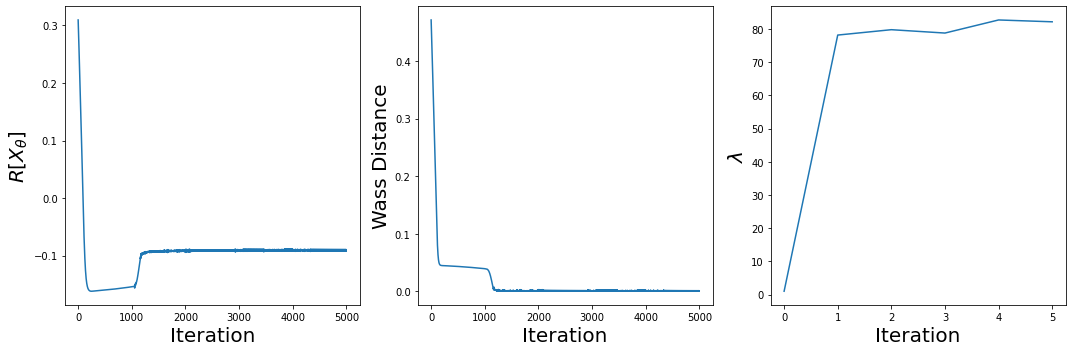

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


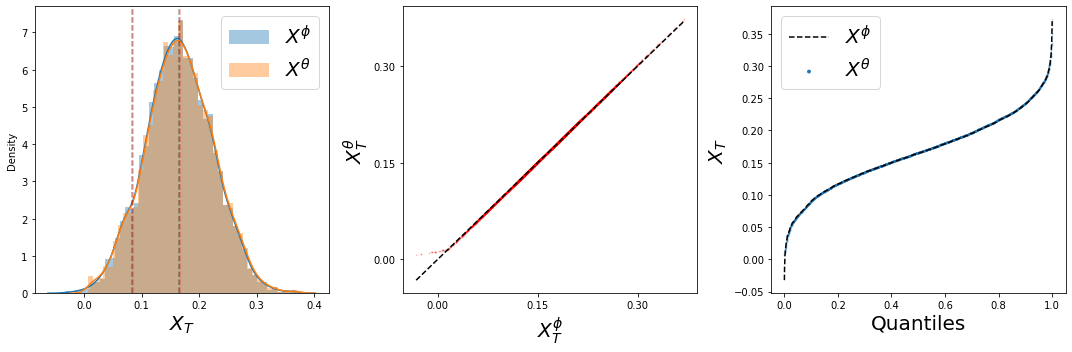

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Outer Epoch: 199 Outer Iter: 0
### Outer Problem Metrics ###
Weights:  [0.01284431 0.0222293  0.01188264 0.01190936 0.08928809 0.14727452
 0.17628367 0.17722239 0.17899369 0.17207202]
Weights Delta:  [-0.00086955 -0.00150913 -0.00082981 -0.00096029 -0.00145674 -0.00133665
  0.00212421  0.00260644 -0.00021952  0.00245103]


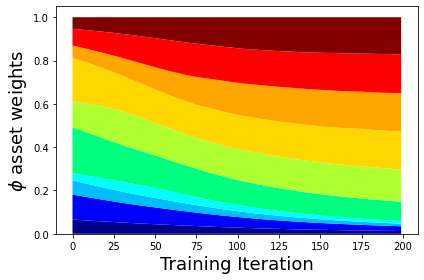

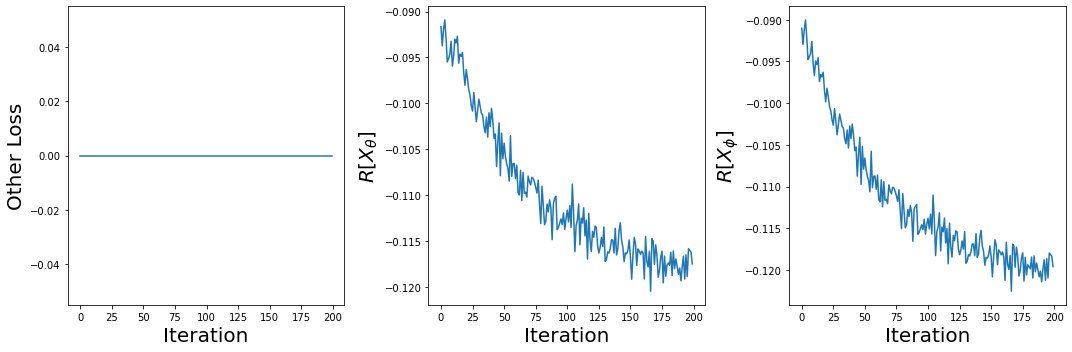

### Inner Problem Metrics ###
Wass Dist History:  [0.0010334684047847986, 0.0010300702415406704, 0.0010112014133483171, 0.000990245840512216, 0.001028253580443561]
Risk Measure X_theta History:  [-0.1193552017211914, -0.11936292052268982, -0.1194080039858818, -0.11946205049753189, -0.1193663626909256]
Loss History:  [-0.01815749518573284, -0.012518772855401039, 0.017896272242069244, 0.12029886990785599, -0.012974249199032784]
Augmented Lagrangian lambda: 2.8019062305102125 mu: 15187.5


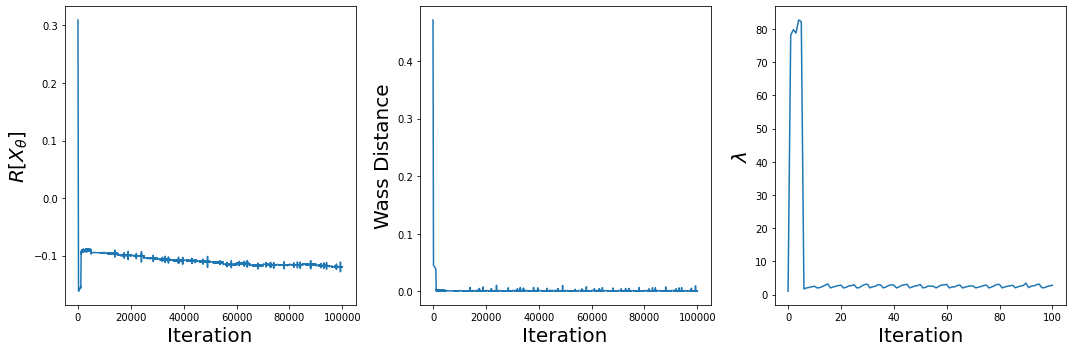

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


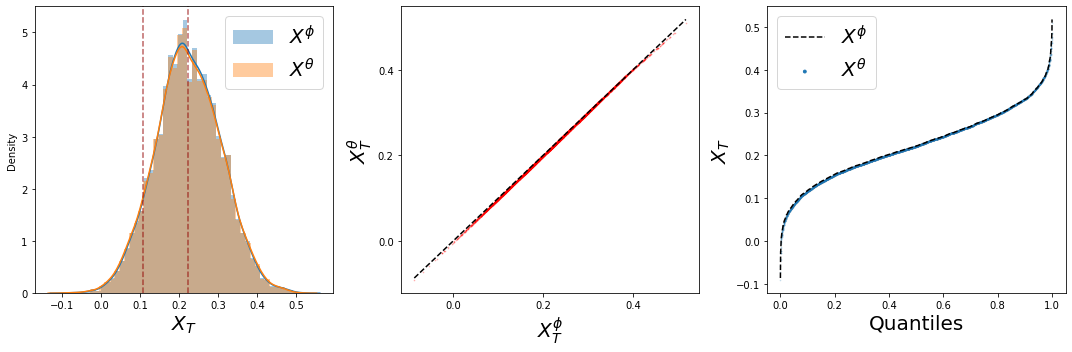

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Outer Epoch: 398 Outer Iter: 0
### Outer Problem Metrics ###
Weights:  [0.00486638 0.00842812 0.00444503 0.00444073 0.08730099 0.15491924
 0.18171045 0.18555734 0.18574944 0.1825823 ]
Weights Delta:  [-1.81281008e-04 -3.13142315e-04 -1.66737940e-04 -1.62000768e-04
 -7.02634454e-04 -8.06763768e-04  1.52771175e-03 -1.44223869e-03
 -7.14808702e-05  2.31866539e-03]


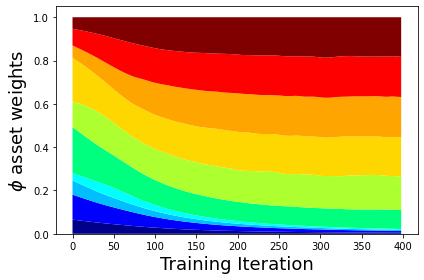

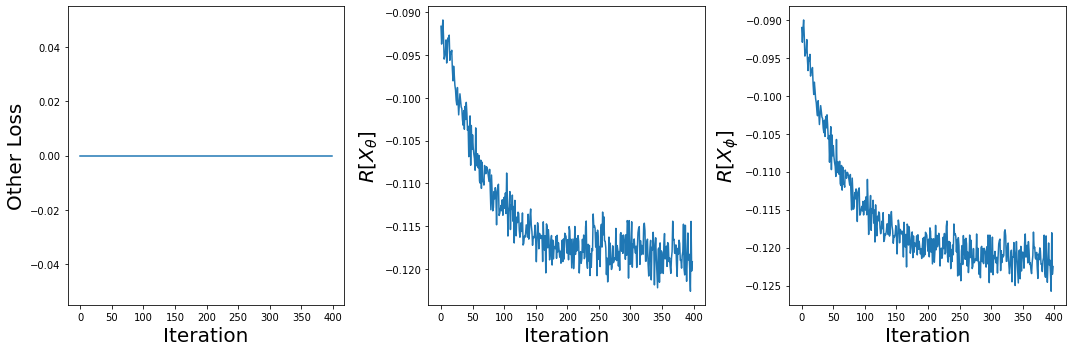

### Inner Problem Metrics ###
Wass Dist History:  [0.0009536922443658113, 0.0009526077774353325, 0.0011832450982183218, 0.000868392875418067, 0.0010731467045843601]
Risk Measure X_theta History:  [-0.11846710741519928, -0.1189776360988617, -0.11932326853275299, -0.1189134418964386, -0.11843057721853256]
Loss History:  [0.1193096786737442, 0.11982112377882004, 1.7541979551315308, 0.11975740641355515, -1.6155056953430176]
Augmented Lagrangian lambda: 6.8419299484812655 mu: 15187.5


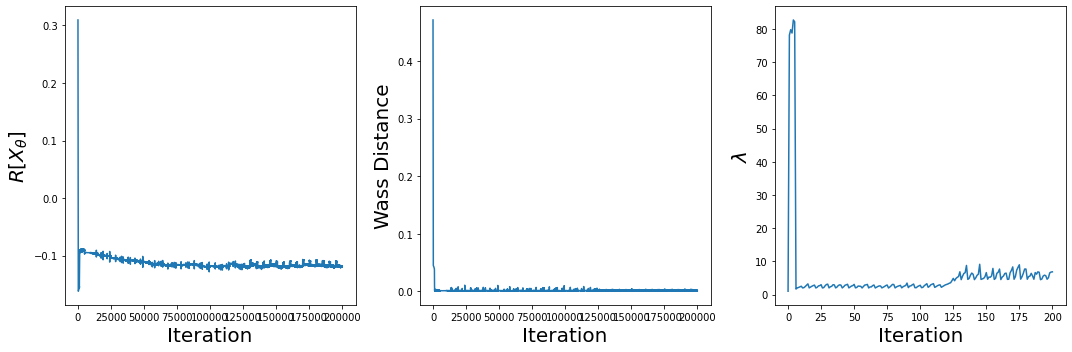

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


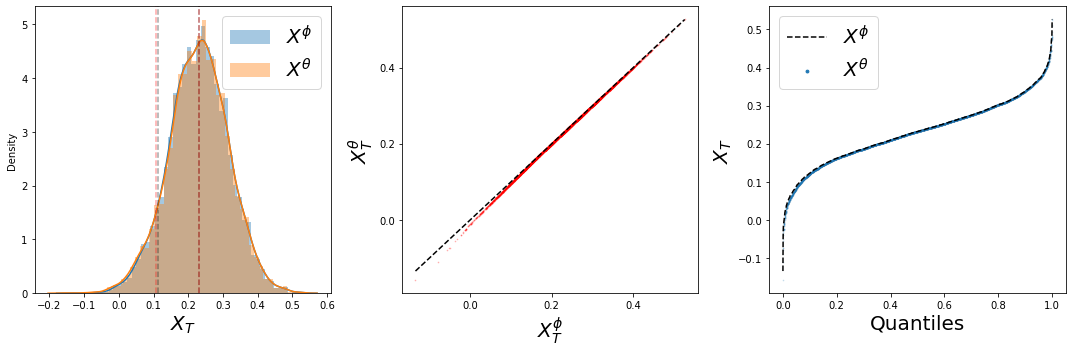

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
inner_net = InnerNet(10).to(device)
outer_net = OuterNet(10).to(device)
inner_name = root_dir + "inner_0.001"
outer_name = root_dir + "outer_0.001"

agent = Robust_Agent(factor_model, sim_params, train_params, device, outer_net, outer_name)
adversary = Robust_Adversary(rm_params, lm_params_0, wass_params_0, train_params, device, inner_net, inner_name)
agent.train(adversary)
np.save(root_dir + "weights_0.001.npy", agent.weights_history)
np.save(root_dir + "X_phi_0.001.npy", agent.X_phi_history)

### Wass 1e-2

In [21]:
LM_param_dict = { "lam": 1,
                  "mu": 200,
                  "mu_update": 1.5,
                  "update_freq": 1000
                  }
wass_param_dict = {"wass_order" : 1,
                   "wass_limit" : 1e-2
                  }

lm_params_1 = LM_Params(LM_param_dict)
wass_params_1 = Wass_Params(wass_param_dict)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Outer Epoch: 0 Outer Iter: 0
### Outer Problem Metrics ###
Weights:  [0.04283863 0.07405271 0.06357811 0.16446674 0.20662415 0.12241273
 0.07507856 0.16153133 0.04452548 0.0448916 ]
Weights Delta:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
### Inner Problem Metrics ###
Wass Dist History:  [0.009492961689829826, 0.009795906953513622, 0.010158287361264229, 0.010717020370066166, 0.010778078809380531]
Risk Measure X_theta History:  [-0.05255257338285446, -0.051038604229688644, -0.0486125573515892, -0.045913953334093094, -0.045156314969062805]
Loss History:  [0.05329548195004463, 0.051728297024965286, 0.9595706462860107, -1.0636945962905884, -1.0526982545852661]
Augmented Lagrangian lambda: 6.657403759658336 mu: 1518.75


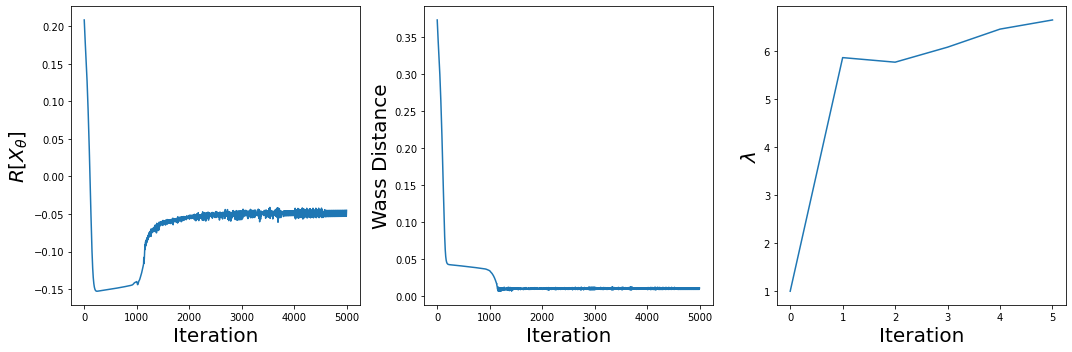

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


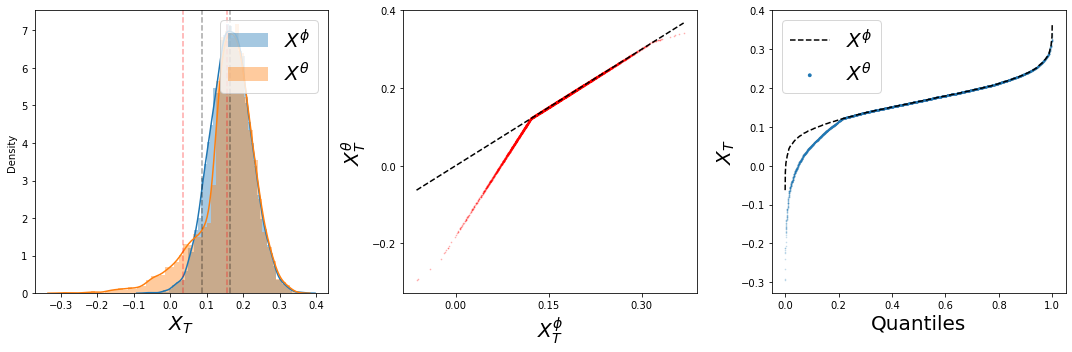

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Outer Epoch: 199 Outer Iter: 0
### Outer Problem Metrics ###
Weights:  [0.01045627 0.01781938 0.01465826 0.06187053 0.11628509 0.1507761
 0.16055258 0.16308734 0.15425526 0.15023921]
Weights Delta:  [-0.00066784 -0.00116768 -0.00102245 -0.0023987  -0.0011893  -0.00085589
 -0.00011483  0.00475259  0.00139908  0.00126506]


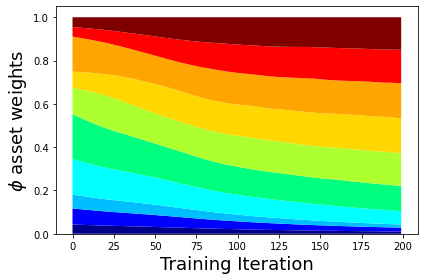

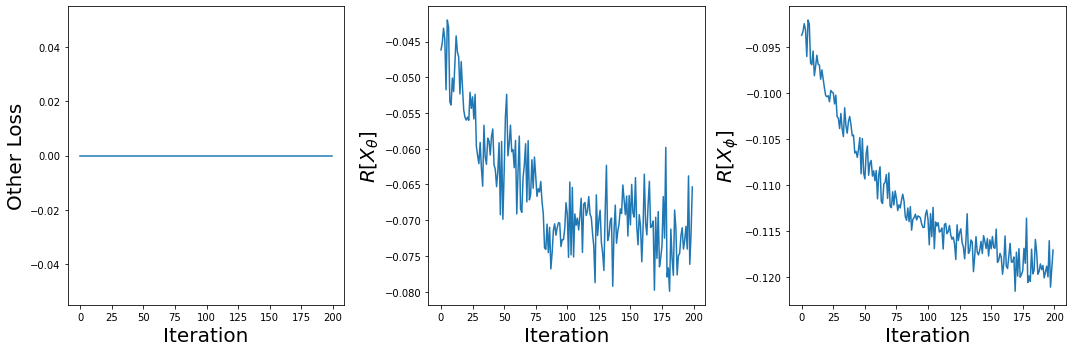

### Inner Problem Metrics ###
Wass Dist History:  [0.0098083121702075, 0.009858905337750912, 0.010106348432600498, 0.010285716503858566, 0.010397739708423615]
Risk Measure X_theta History:  [-0.07434599846601486, -0.07434608042240143, -0.07368416339159012, -0.0724216103553772, -0.0719342902302742]
Loss History:  [0.07569654285907745, 0.07569855451583862, 1.0819547176361084, -0.6375699043273926, -0.6650651693344116]
Augmented Lagrangian lambda: 5.41768553527072 mu: 1518.75


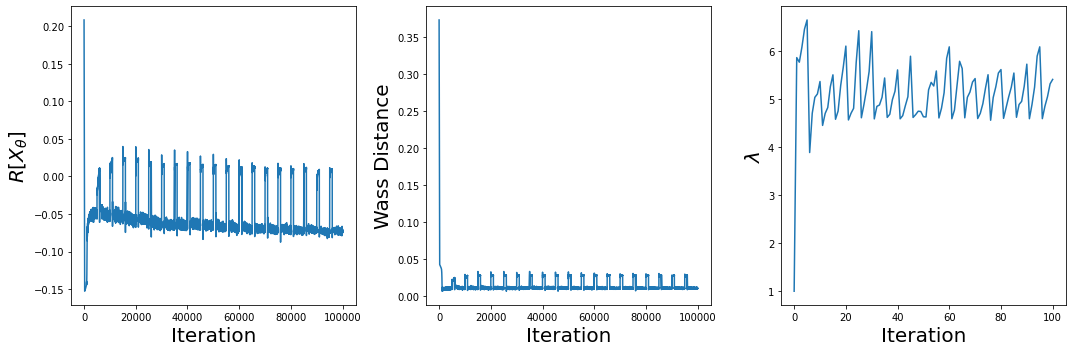

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


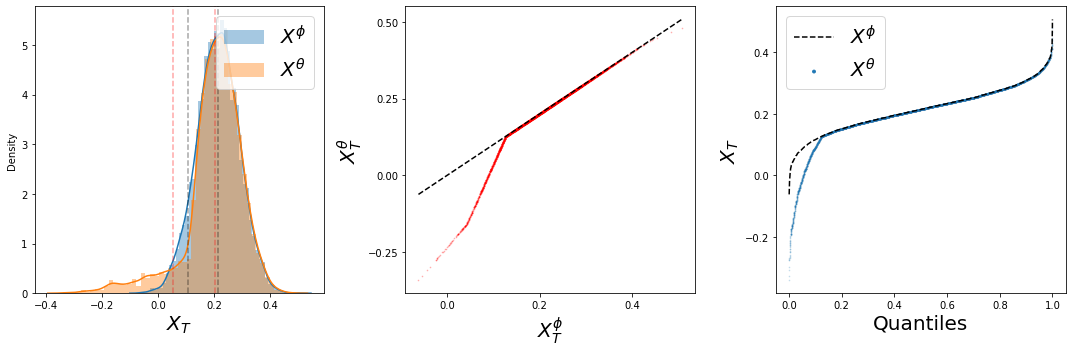

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Outer Epoch: 398 Outer Iter: 0
### Outer Problem Metrics ###
Weights:  [0.00417493 0.00687518 0.00505222 0.02735791 0.09402592 0.15297402
 0.1729891  0.17736018 0.1816228  0.17756769]
Weights Delta:  [-0.00015231 -0.0002596  -0.00021557 -0.00098157  0.00047795  0.00016028
  0.00117652 -0.00017948  0.00072767 -0.00075392]


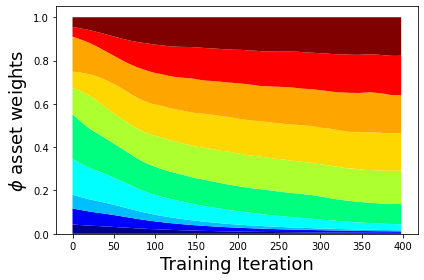

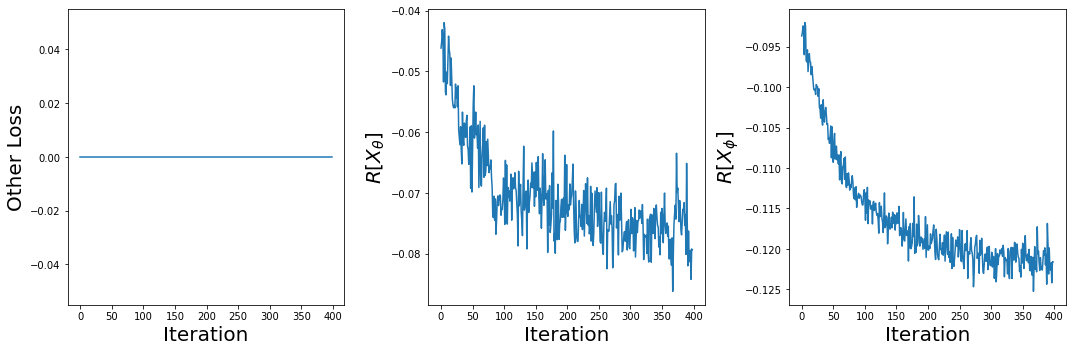

### Inner Problem Metrics ###
Wass Dist History:  [0.010764635168015957, 0.010790751315653324, 0.01004741620272398, 0.010711900889873505, 0.010940540581941605]
Risk Measure X_theta History:  [-0.07220042496919632, -0.07214938849210739, -0.07295192778110504, -0.07428968697786331, -0.07488828152418137]
Loss History:  [-1.2237011194229126, -1.2292659282684326, -1.00858473777771, 1.2226977348327637, 1.2726515531539917]
Augmented Lagrangian lambda: 5.930960977915674 mu: 1518.75


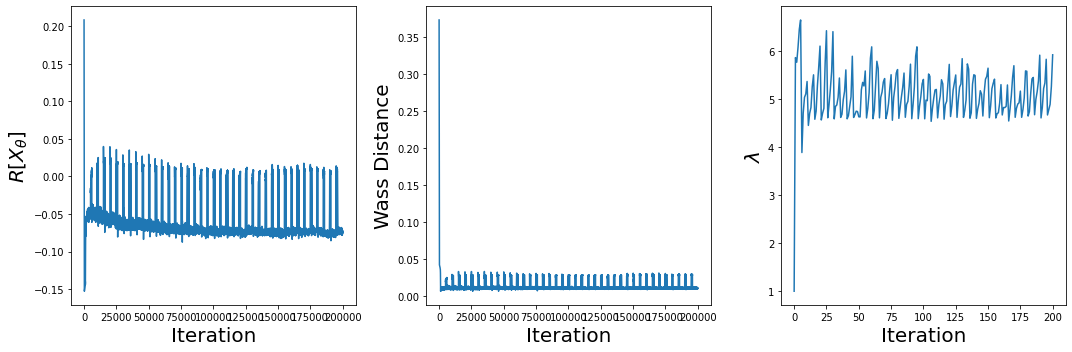

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


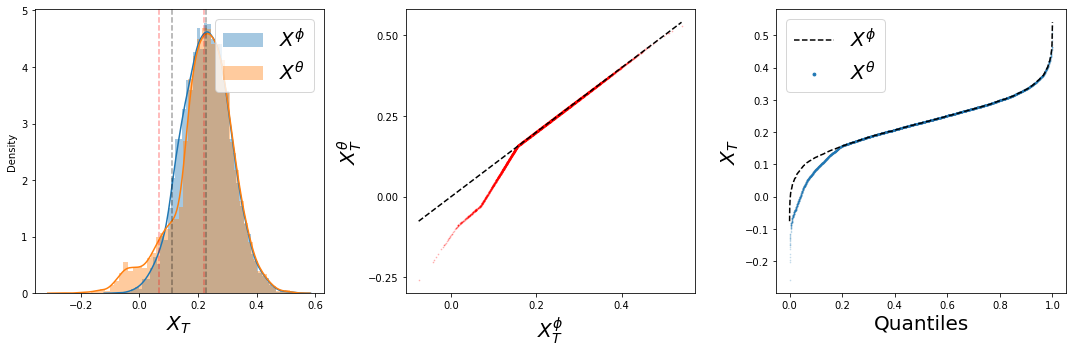

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
inner_net = InnerNet(10).to(device)
outer_net = OuterNet(10).to(device)
inner_name = root_dir + "inner_0.01"
outer_name = root_dir + "outer_0.01"

agent = Robust_Agent(factor_model, sim_params, train_params, device, outer_net, outer_name)
adversary = Robust_Adversary(rm_params, lm_params_1, wass_params_1, train_params, device, inner_net, inner_name)
agent.train(adversary)
np.save(root_dir + "weights_0.01.npy", agent.weights_history)
np.save(root_dir + "X_phi_0.01.npy", agent.X_phi_history)

### Wass 1e-1

In [22]:
LM_param_dict = { "lam": 1,
                  "mu": 20,
                  "mu_update": 1.5,
                  "update_freq": 1000
                  }
wass_param_dict = {"wass_order" : 1,
                   "wass_limit" : 1e-1
                  }

lm_params_2 = LM_Params(LM_param_dict)
wass_params_2 = Wass_Params(wass_param_dict)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Outer Epoch: 0 Outer Iter: 0
### Outer Problem Metrics ###
Weights:  [0.07361166 0.10818339 0.05252301 0.041304   0.04649146 0.04244994
 0.14513598 0.20541143 0.1506526  0.13423653]
Weights Delta:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
### Inner Problem Metrics ###
Wass Dist History:  [0.10031687468290329, 0.10097075253725052, 0.10199414193630219, 0.10042695701122284, 0.09922031313180923]
Risk Measure X_theta History:  [0.35556018352508545, 0.35861921310424805, 0.35887008905410767, 0.356499046087265, 0.3519138693809509]
Loss History:  [0.9850038290023804, -0.8225950598716736, -0.8270639777183533, -0.8181155323982239, -0.34473177790641785]
Augmented Lagrangian lambda: 5.067223699763416 mu: 151.875


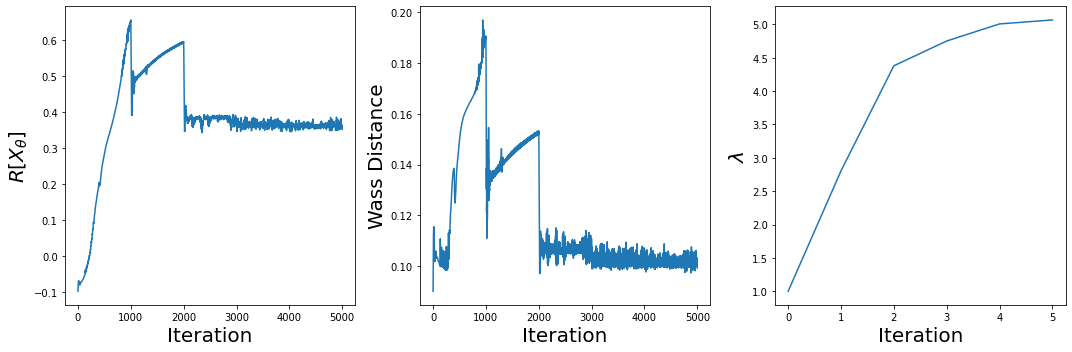

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


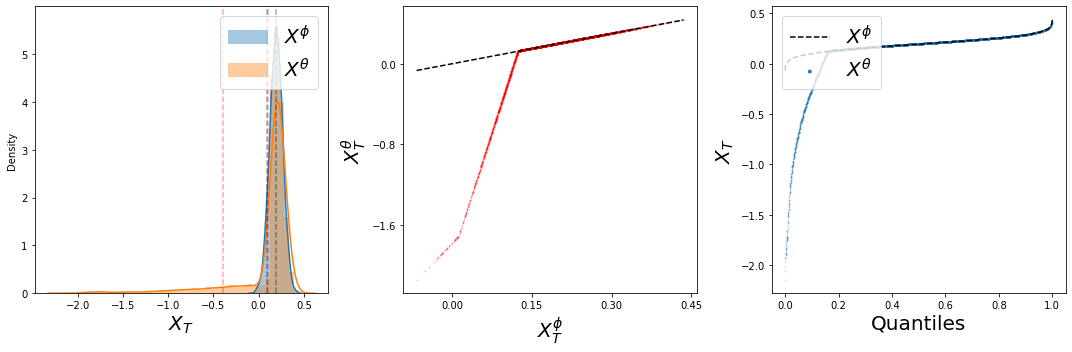

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Outer Epoch: 199 Outer Iter: 0
### Outer Problem Metrics ###
Weights:  [0.01381586 0.02062766 0.01063702 0.09111353 0.13588972 0.14733581
 0.15216397 0.15135692 0.14371008 0.13334945]
Weights Delta:  [-0.00090188 -0.0013519  -0.00068647  0.00032545  0.00071703  0.00036296
  0.00361373  0.00191894 -0.00164171 -0.00235619]


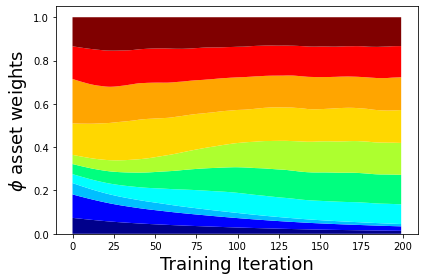

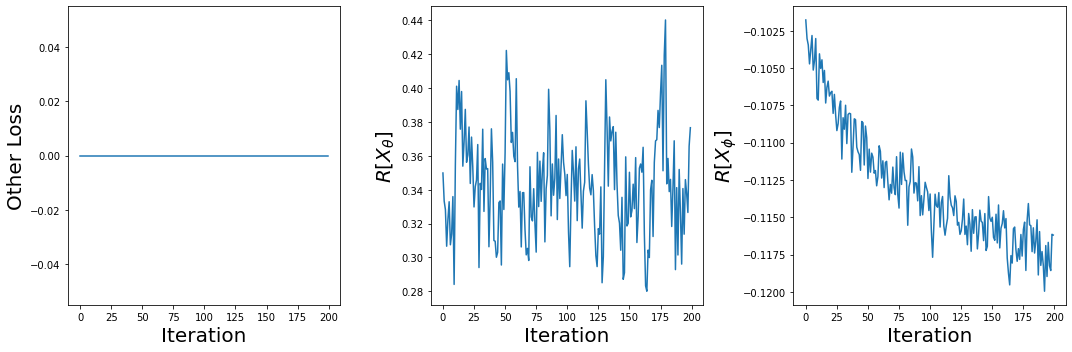

### Inner Problem Metrics ###
Wass Dist History:  [0.10226830840110779, 0.10251770168542862, 0.10059112310409546, 0.10412300378084183, 0.10611388832330704]
Risk Measure X_theta History:  [0.343980073928833, 0.344075083732605, 0.3464897572994232, 0.35098299384117126, 0.35278093814849854]
Loss History:  [1.161365032196045, 1.1699855327606201, 1.1004760265350342, -0.8786431550979614, -0.8904433250427246]
Augmented Lagrangian lambda: 5.151074791327118 mu: 151.875


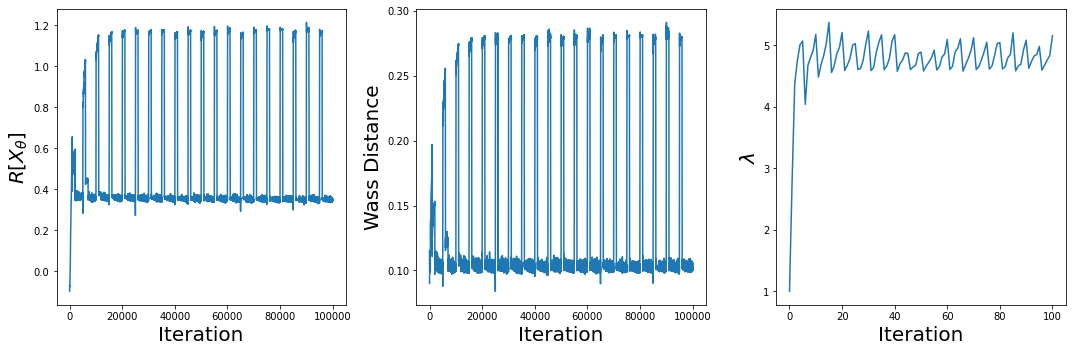

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


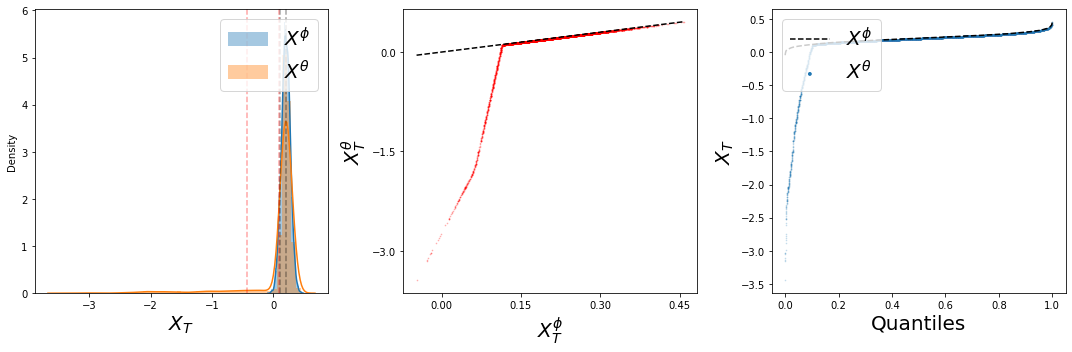

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Outer Epoch: 398 Outer Iter: 0
### Outer Problem Metrics ###
Weights:  [0.00560085 0.00826299 0.00380713 0.06964394 0.13607441 0.1548605
 0.16149105 0.16053106 0.15336891 0.14635919]
Weights Delta:  [-0.00019574 -0.00029718 -0.0001699  -0.00125615  0.00097276  0.0011272
  0.00272897 -0.00090602 -0.00217901  0.00017506]


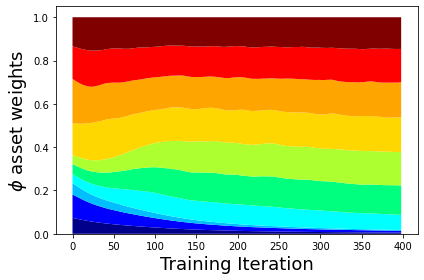

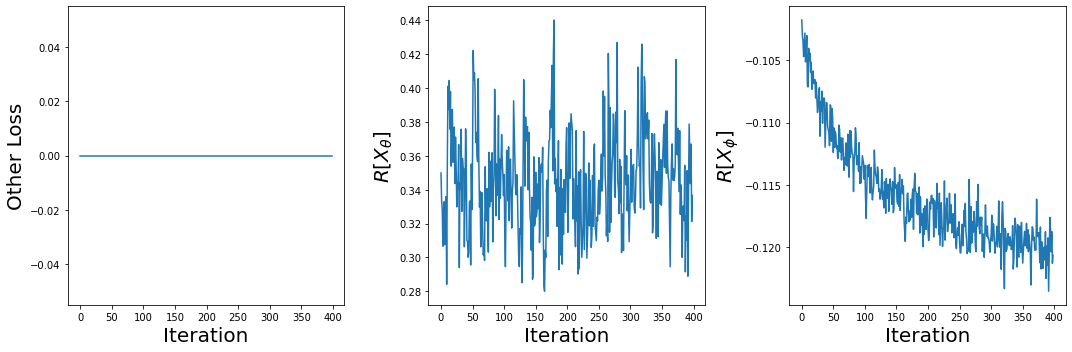

### Inner Problem Metrics ###
Wass Dist History:  [0.10278443247079849, 0.10350235551595688, 0.10272791236639023, 0.10217805951833725, 0.10323791205883026]
Risk Measure X_theta History:  [0.34570077061653137, 0.3458992540836334, 0.34772977232933044, 0.3510267734527588, 0.3521551489830017]
Loss History:  [1.192319631576538, 1.2169100046157837, 1.188122272491455, -0.9330312609672546, -0.9405375123023987]
Augmented Lagrangian lambda: 5.332649696618318 mu: 151.875


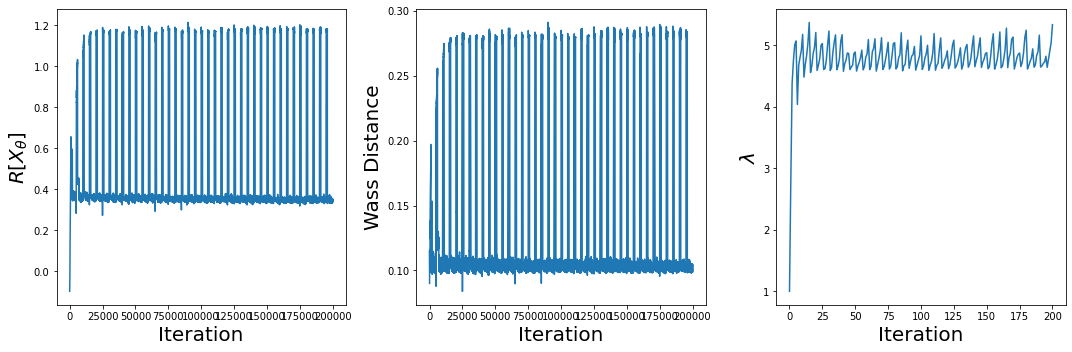

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


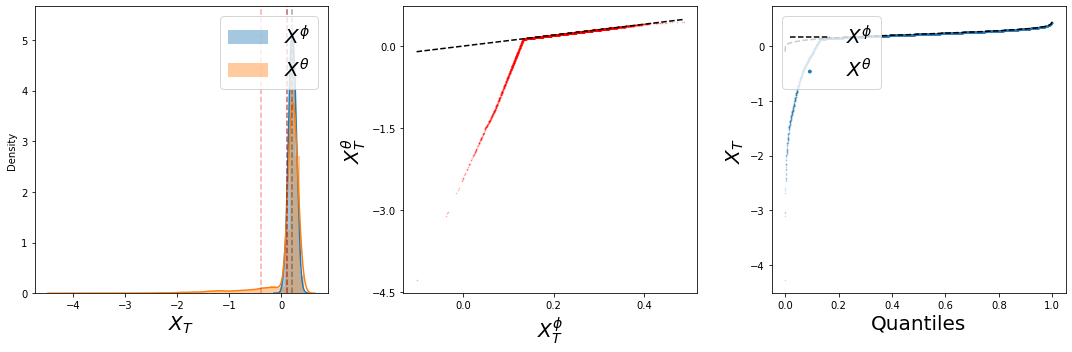

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
inner_net = InnerNet(10).to(device)
outer_net = OuterNet(10).to(device)
inner_name = root_dir + "inner_0.1"
outer_name = root_dir + "outer_0.1"

agent = Robust_Agent(factor_model, sim_params, train_params, device, outer_net, outer_name)
adversary = Robust_Adversary(rm_params, lm_params_2, wass_params_2, train_params, device, inner_net, inner_name)
agent.train(adversary)
np.save(root_dir + "weights_0.1.npy", agent.weights_history)
np.save(root_dir + "X_phi_0.1.npy", agent.X_phi_history)

### Wass 1

In [23]:
LM_param_dict = { "lam": 1,
                  "mu": 2,
                  "mu_update": 1.5,
                  "update_freq": 1000
                  }
wass_param_dict = {"wass_order" : 1,
                   "wass_limit" : 1
                  }

lm_params_3 = LM_Params(LM_param_dict)
wass_params_3 = Wass_Params(wass_param_dict)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Outer Epoch: 0 Outer Iter: 0
### Outer Problem Metrics ###
Weights:  [0.0768247  0.06906711 0.09084494 0.1213837  0.16897562 0.12936111
 0.02968734 0.15905553 0.02712451 0.1276754 ]
Weights Delta:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
### Inner Problem Metrics ###
Wass Dist History:  [1.0203659534454346, 1.0210648775100708, 1.0232418775558472, 1.0216130018234253, 1.0214653015136719]
Risk Measure X_theta History:  [4.62666130065918, 4.628240585327148, 4.636265754699707, 4.631677150726318, 4.631484508514404]
Loss History:  [0.19893522560596466, 0.5152752995491028, -0.1685081124305725, 0.41815832257270813, 0.3331630527973175]
Augmented Lagrangian lambda: 4.837143591046333 mu: 15.1875


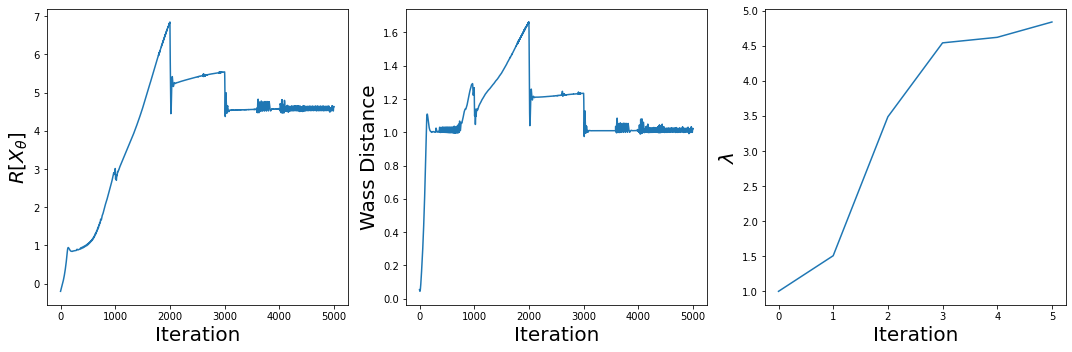

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


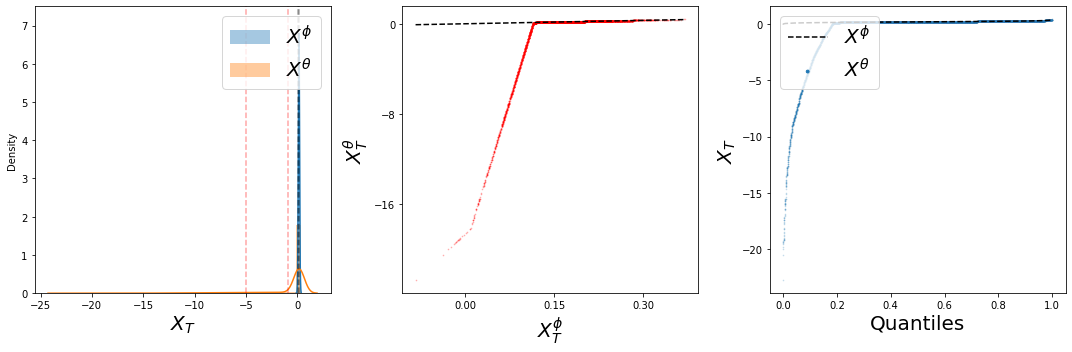

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Outer Epoch: 199 Outer Iter: 0
### Outer Problem Metrics ###
Weights:  [0.02018522 0.01779363 0.02699545 0.09426609 0.13597186 0.14872853
 0.1434509  0.14393239 0.13481361 0.13386233]
Weights Delta:  [-0.00136378 -0.00122039 -0.00163976 -0.00118763  0.00242212  0.00226553
  0.00020985 -0.00231205  0.0006302   0.00219597]


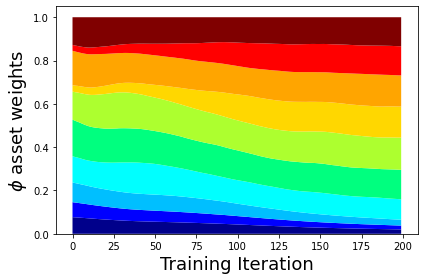

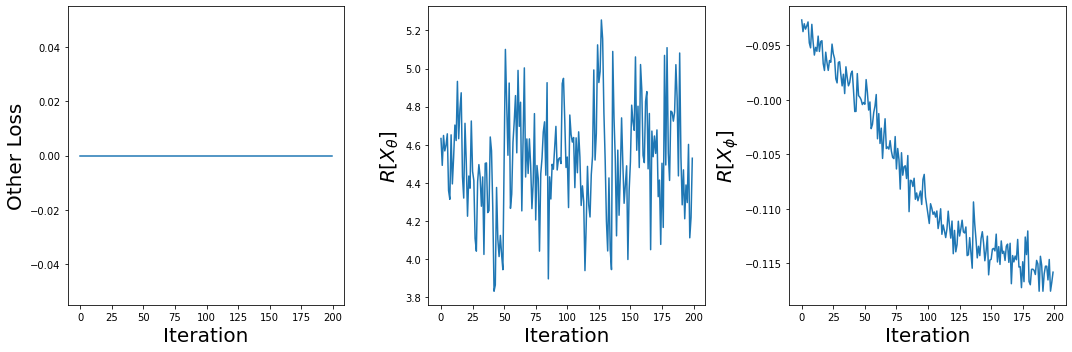

### Inner Problem Metrics ###
Wass Dist History:  [1.0057597160339355, 1.0049402713775635, 1.009764313697815, 1.0083783864974976, 1.0068979263305664]
Risk Measure X_theta History:  [4.536733150482178, 4.539853572845459, 4.547037601470947, 4.545205593109131, 4.535337448120117]
Loss History:  [1.3676985502243042, 0.8612539172172546, -0.49985113739967346, -0.5147584676742554, 1.3883846998214722]
Augmented Lagrangian lambda: 4.9234987676143644 mu: 15.1875


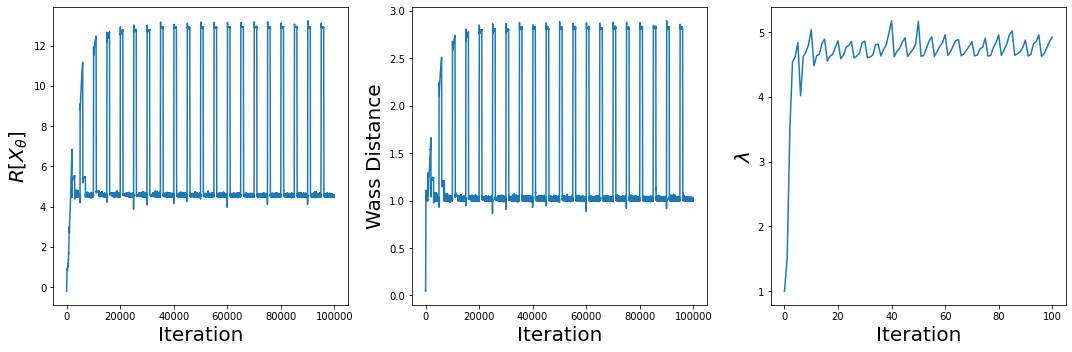

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


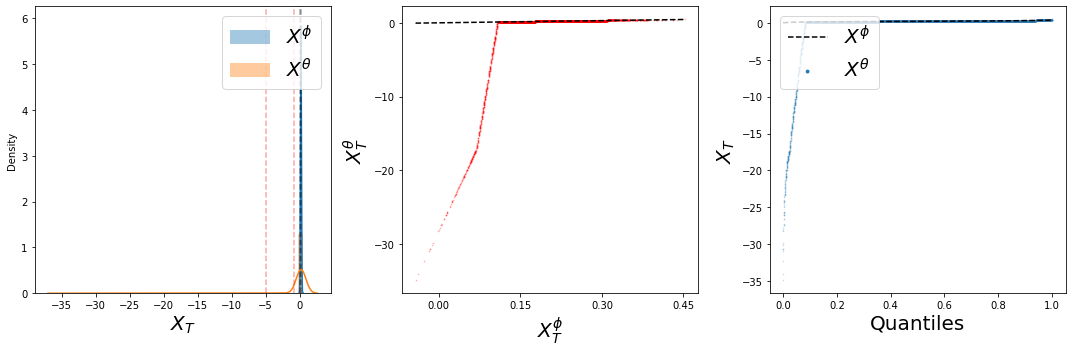

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Outer Epoch: 398 Outer Iter: 0
### Outer Problem Metrics ###
Weights:  [0.00826809 0.00723179 0.01194366 0.08929786 0.14477852 0.15851133
 0.15338798 0.14746293 0.14387669 0.13524117]
Weights Delta:  [-0.00031069 -0.00027409 -0.00036601  0.00088347 -0.00103536  0.00448678
 -0.00036052 -0.00239848 -0.00100388  0.00037879]


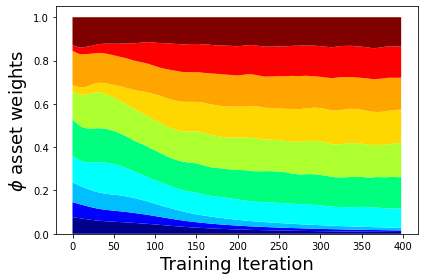

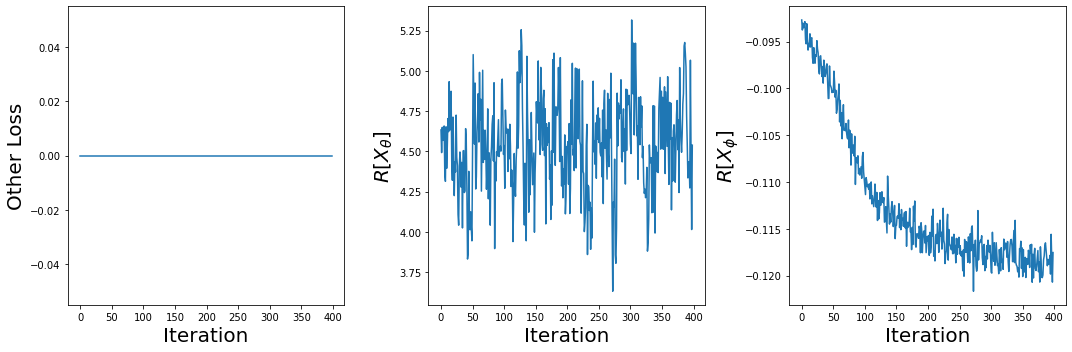

### Inner Problem Metrics ###
Wass Dist History:  [1.0051991939544678, 1.0063800811767578, 1.0070416927337646, 1.0081087350845337, 1.0078825950622559]
Risk Measure X_theta History:  [4.533545970916748, 4.538992881774902, 4.540621280670166, 4.546266078948975, 4.546332359313965]
Loss History:  [0.009457185864448547, 0.013543650507926941, 0.8089026808738708, -0.1454462707042694, 0.3263613283634186]
Augmented Lagrangian lambda: 4.904751273989677 mu: 15.1875


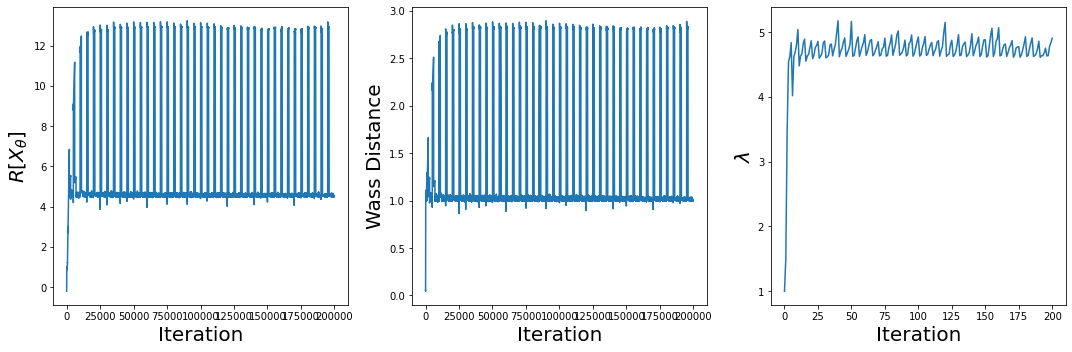

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


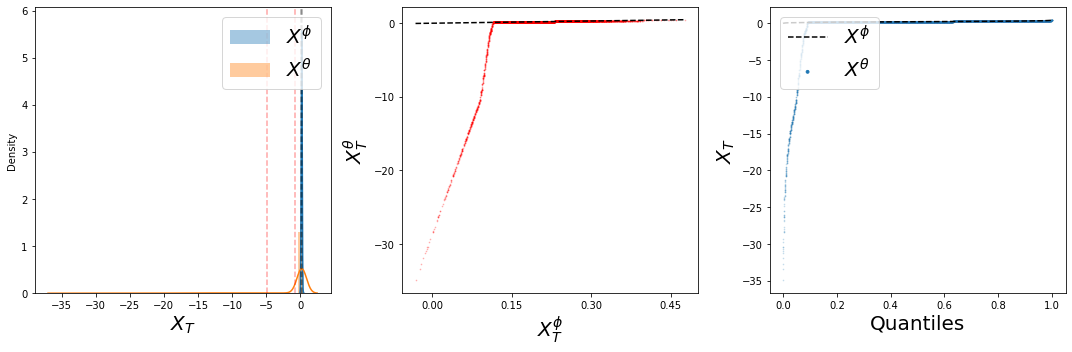

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
inner_net = InnerNet(10).to(device)
outer_net = OuterNet(10).to(device)
inner_name = root_dir + "inner_1"
outer_name = root_dir + "outer_1"

agent = Robust_Agent(factor_model, sim_params, train_params, device, outer_net, outer_name)
adversary = Robust_Adversary(rm_params, lm_params_3, wass_params_3, train_params, device, inner_net, inner_name)
agent.train(adversary)
np.save(root_dir + "weights_1.npy", agent.weights_history)
np.save(root_dir + "X_phi_1.npy", agent.X_phi_history)

## Alpha-Beta Risk Measure

$\alpha = 0.1, \beta = 0.9, p = 0.75$

In [19]:
RM_param_dict = { "alpha" : 0.1,
                  "beta" : 0.9,
                   "p" : 0.75,
                  "rm_type" : 'alpha-beta'
                  }
                  
rm_params = RM_Params(RM_param_dict)

### Wass 1e-3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Outer Epoch: 0 Outer Iter: 0
### Outer Problem Metrics ###
Weights:  [0.13158706 0.05448991 0.19334929 0.08949805 0.0503697  0.05133954
 0.06548532 0.07594136 0.18170014 0.1062396 ]
Weights Delta:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
### Inner Problem Metrics ###
Wass Dist History:  [0.0009357140515930951, 0.0009930109372362494, 0.0011159455170854926, 0.0009582721395418048, 0.0008976640528999269]
Risk Measure X_theta History:  [-0.11132465302944183, -0.1112024337053299, -0.11099550873041153, -0.11127346009016037, -0.11142687499523163]
Loss History:  [0.11169710010290146, 0.11157479882240295, -0.5793910026550293, 0.11164591461420059, 0.11179950088262558]
Augmented Lagrangian lambda: 7.234953908831812 mu: 15187.5


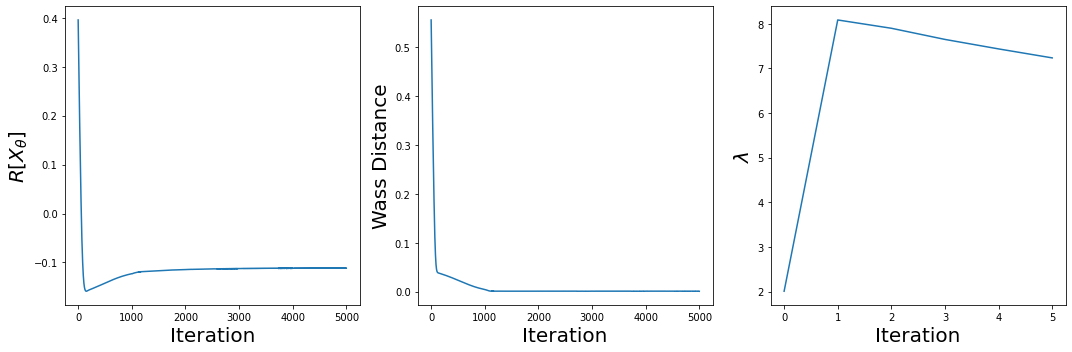

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


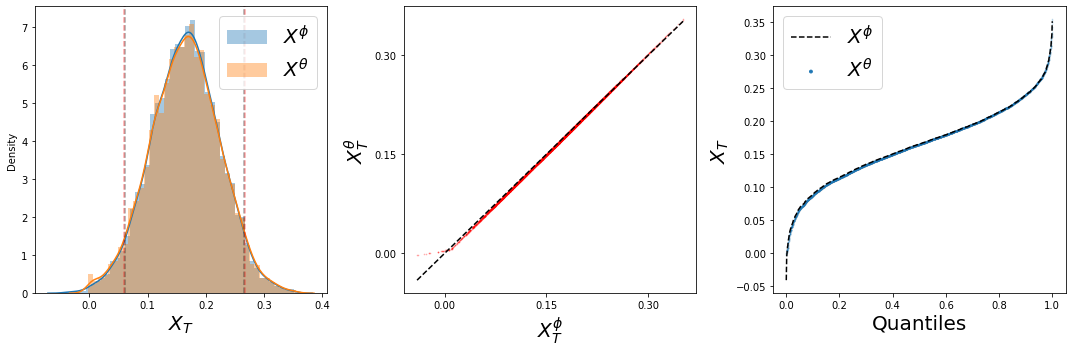

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Outer Epoch: 199 Outer Iter: 0
### Outer Problem Metrics ###
Weights:  [0.01921113 0.00778778 0.0284425  0.01228479 0.04711218 0.12474175
 0.17113847 0.18846461 0.20586298 0.19495381]
Weights Delta:  [-0.00138381 -0.00057078 -0.00205873 -0.00093431 -0.0025352  -0.00168318
  0.00122575  0.00095464  0.00457719  0.00240837]


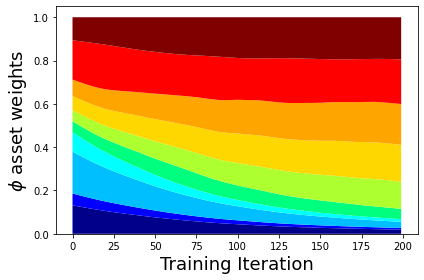

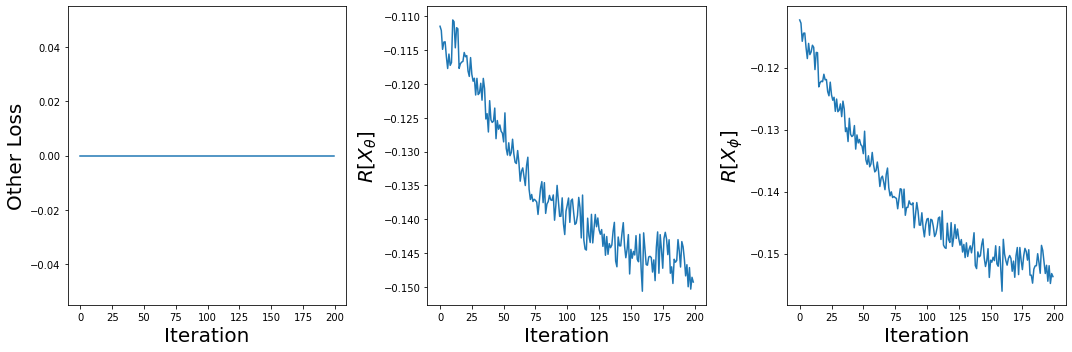

### Inner Problem Metrics ###
Wass Dist History:  [0.0012670988216996193, 0.0007395186112262309, 0.0008884005364961922, 0.0011661143507808447, 0.0007341006421484053]
Risk Measure X_theta History:  [-0.14347031712532043, -0.14404840767383575, -0.14446395635604858, -0.14473332464694977, -0.14403706789016724]
Loss History:  [-2.5045931339263916, 0.14461547136306763, 0.14503121376037598, 2.5477049350738525, 0.14460426568984985]
Augmented Lagrangian lambda: 8.599617040075827 mu: 15187.5


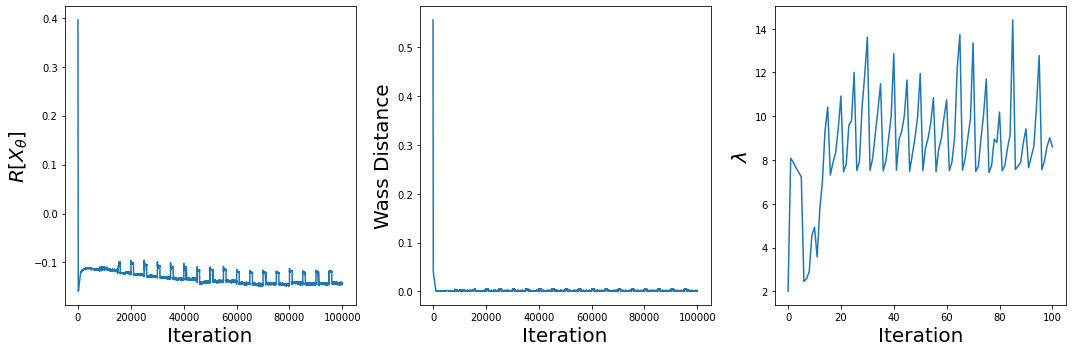

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


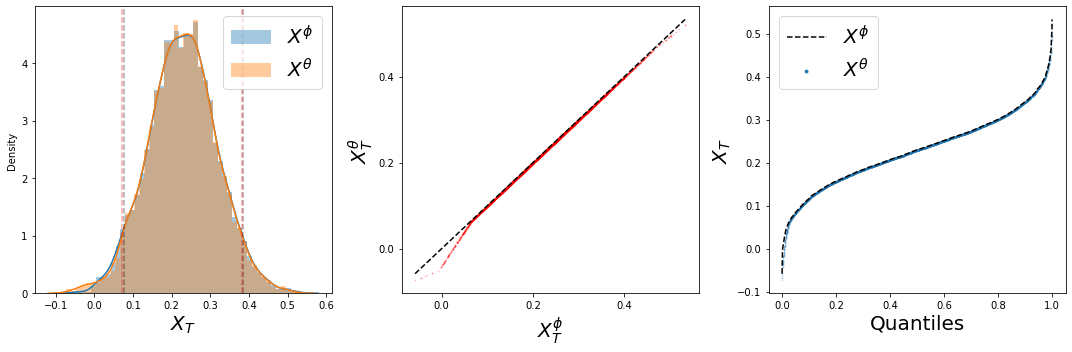

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Outer Epoch: 398 Outer Iter: 0
### Outer Problem Metrics ###
Weights:  [0.00703291 0.00280272 0.01029628 0.00403333 0.02070717 0.12690865
 0.18283367 0.20627345 0.22038774 0.21872415]
Weights Delta:  [-0.00028913 -0.00011683 -0.00042397 -0.00017298 -0.00041708  0.00376026
 -0.00248735 -0.00054774  0.00327718 -0.00258231]


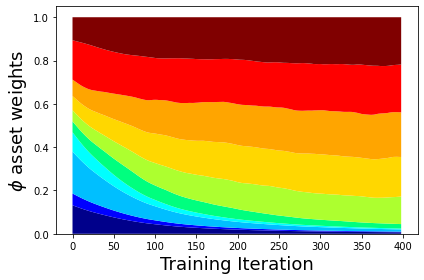

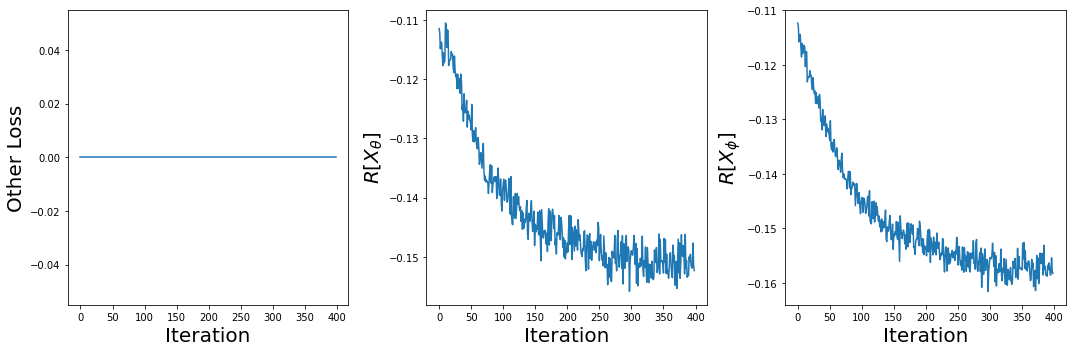

### Inner Problem Metrics ###
Wass Dist History:  [0.001131456228904426, 0.0010207409504801035, 0.001005144091323018, 0.0010499968193471432, 0.0011027278378605843]
Risk Measure X_theta History:  [-0.150382399559021, -0.14995045959949493, -0.15015928447246552, -0.14989443123340607, -0.15027658641338348]
Loss History:  [2.475433826446533, -2.0653185844421387, 1.6918660402297974, -2.1360995769500732, 2.4196927547454834]
Augmented Lagrangian lambda: 9.662681469111703 mu: 15187.5


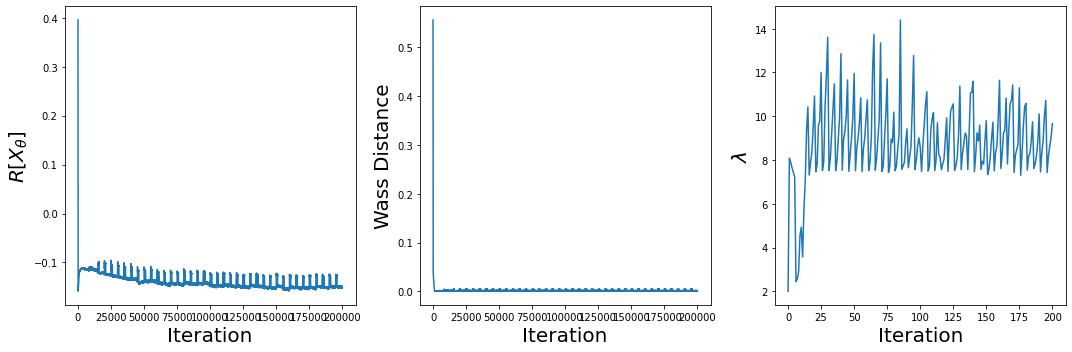

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


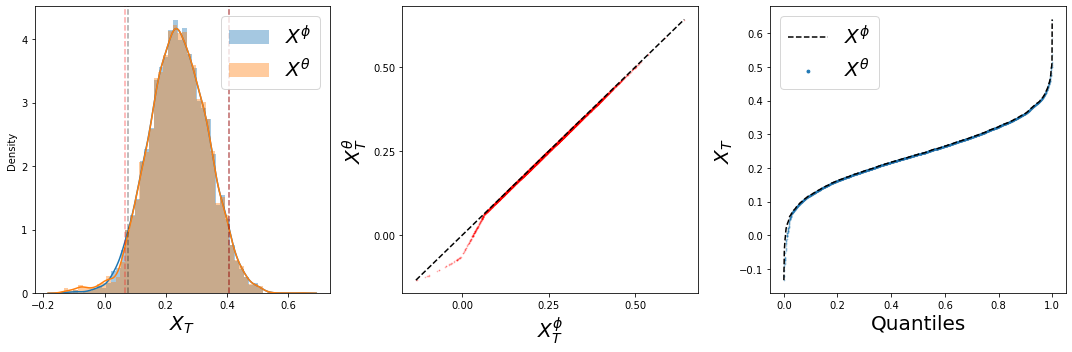

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
inner_net = InnerNet(10).to(device)
outer_net = OuterNet(10).to(device)
inner_name = root_dir + "inner_ab_0.001"
outer_name = root_dir + "outer_ab_0.001"

agent = Robust_Agent(factor_model, sim_params, train_params, device, outer_net, outer_name)
adversary = Robust_Adversary(rm_params, lm_params_0, wass_params_0, train_params, device, inner_net, inner_name)
agent.train(adversary)
np.save(root_dir + "weights_0.001.npy", agent.weights_history)
np.save(root_dir + "X_phi_0.001.npy", agent.X_phi_history)

### Wass 1e-2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Outer Epoch: 0 Outer Iter: 0
### Outer Problem Metrics ###
Weights:  [0.17418909 0.03027797 0.04759523 0.14967172 0.1520182  0.07577906
 0.14100863 0.02698405 0.10422419 0.09825183]
Weights Delta:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
### Inner Problem Metrics ###
Wass Dist History:  [0.010042200796306133, 0.009918687865138054, 0.010094376280903816, 0.010211030021309853, 0.010222271084785461]
Risk Measure X_theta History:  [-0.08710898458957672, -0.08750048279762268, -0.08695384860038757, -0.08662614971399307, -0.08659552037715912]
Loss History:  [-0.004575659055262804, 0.08752988278865814, -0.015355950221419334, -0.030266275629401207, -0.03212955221533775]
Augmented Lagrangian lambda: 3.402404462452978 mu: 1518.75


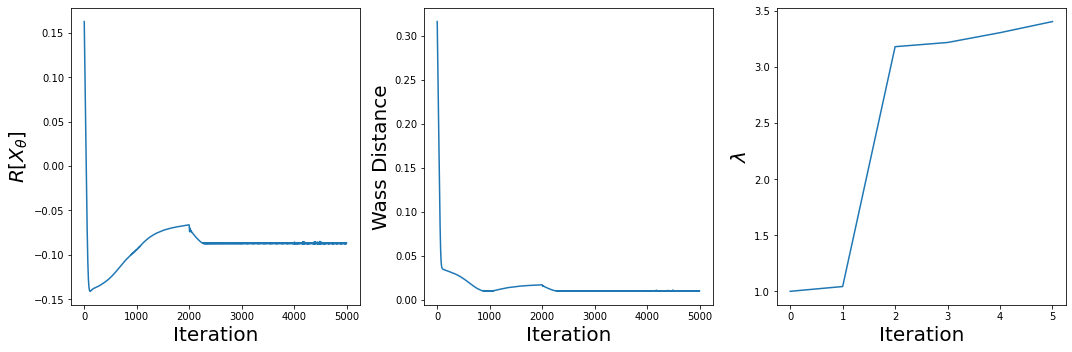

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


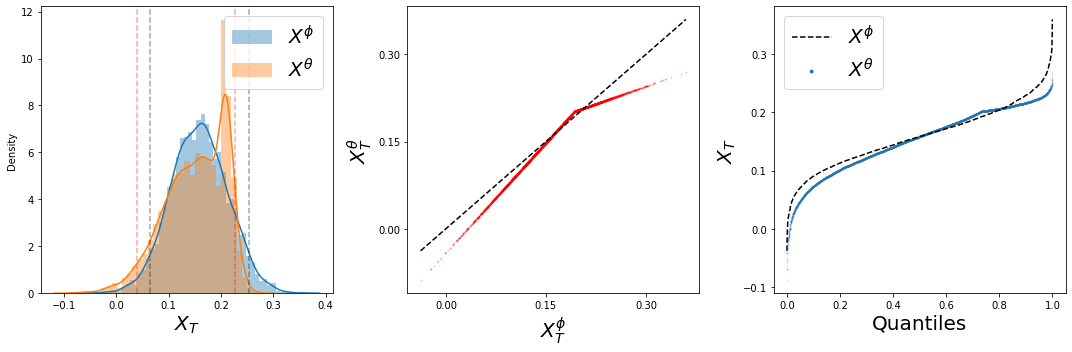

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Outer Epoch: 199 Outer Iter: 0
### Outer Problem Metrics ###
Weights:  [0.03449032 0.00586605 0.02103809 0.10681653 0.13479842 0.14317226
 0.14930362 0.13967718 0.13762908 0.12720849]
Weights Delta:  [-0.00233828 -0.00043227 -0.00156547 -0.00026203  0.00148317 -0.00083694
  0.00256018  0.00147432 -0.00022399  0.00014132]


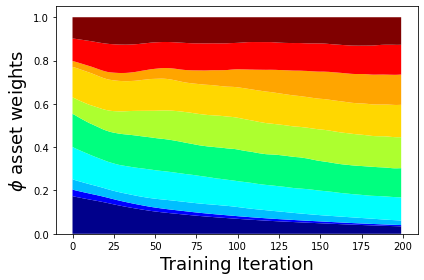

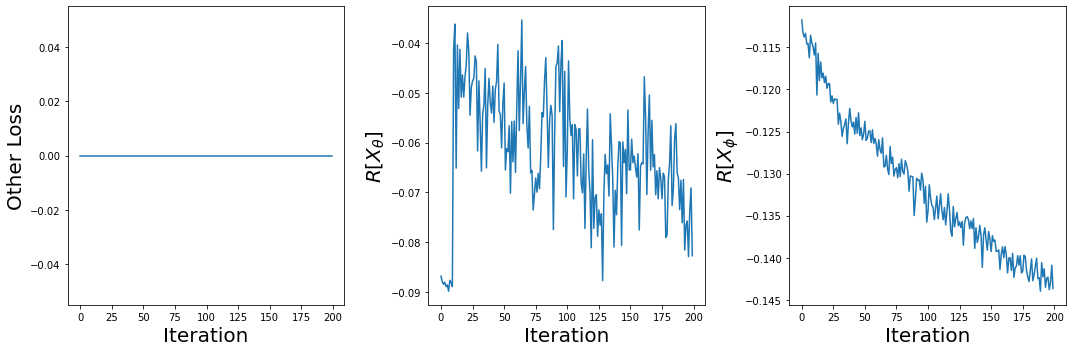

### Inner Problem Metrics ###
Wass Dist History:  [0.010720946826040745, 0.009889128617942333, 0.010041403584182262, 0.009692134335637093, 0.010145679116249084]
Risk Measure X_theta History:  [-0.06730841845273972, -0.06809017062187195, -0.06853362917900085, -0.06807515025138855, -0.0674045979976654]
Loss History:  [-1.6907246112823486, 0.06905239075422287, 1.8186588287353516, 0.06904371827840805, -1.5841679573059082]
Augmented Lagrangian lambda: 8.56512693548575 mu: 1518.75


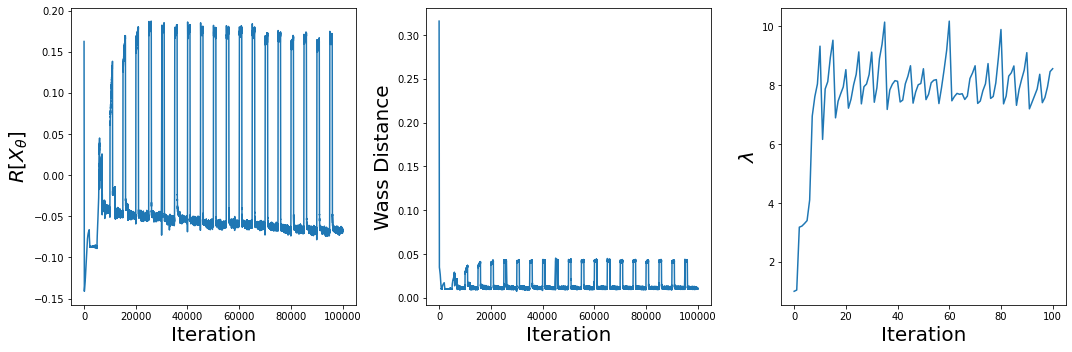

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


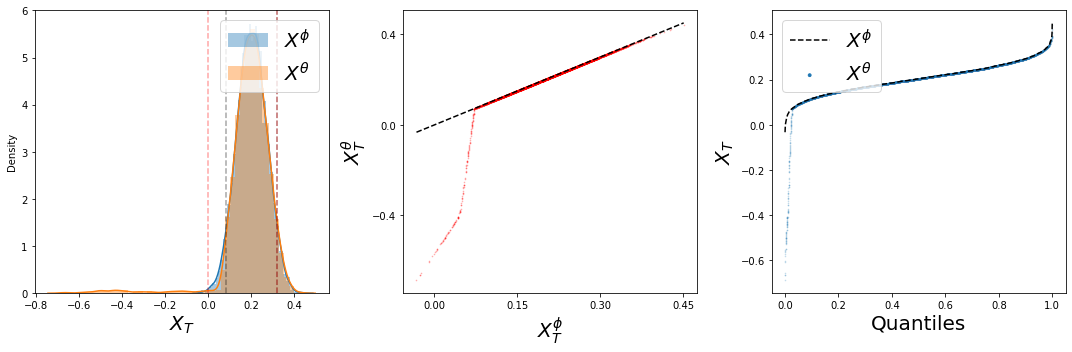

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Outer Epoch: 398 Outer Iter: 0
### Outer Problem Metrics ###
Weights:  [0.01368414 0.00215668 0.0066463  0.08522048 0.13598308 0.14848873
 0.16538131 0.14981651 0.14551805 0.1471047 ]
Weights Delta:  [-4.95932065e-04 -8.50206707e-05 -4.17738687e-04 -1.69251114e-03
 -1.92314386e-04 -1.87185407e-03 -2.58237123e-04  1.41590834e-04
  3.04433703e-03  1.82759762e-03]


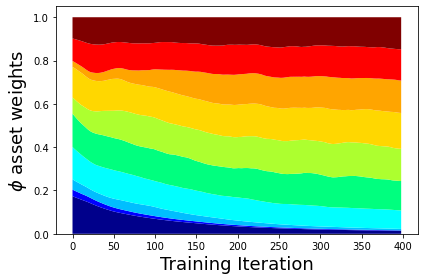

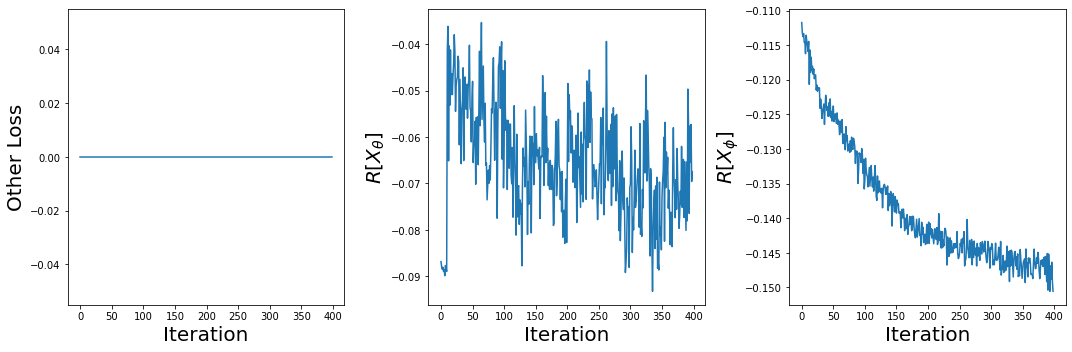

### Inner Problem Metrics ###
Wass Dist History:  [0.00987845566123724, 0.01073337160050869, 0.010679361410439014, 0.009814216755330563, 0.010162923485040665]
Risk Measure X_theta History:  [-0.07846744358539581, -0.07942810654640198, -0.07956766337156296, -0.07897087186574936, -0.07814382016658783]
Loss History:  [0.07944847643375397, 2.149669885635376, 2.137274742126465, 0.07995181530714035, -1.7126563787460327]
Augmented Lagrangian lambda: 8.925086994189769 mu: 1518.75


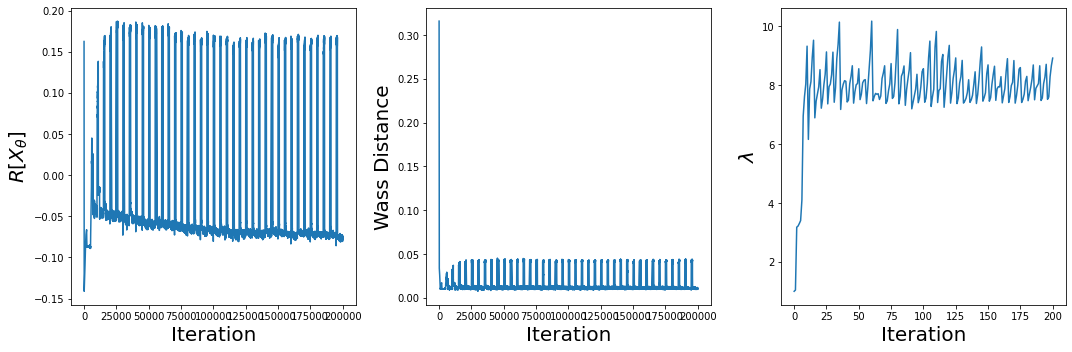

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


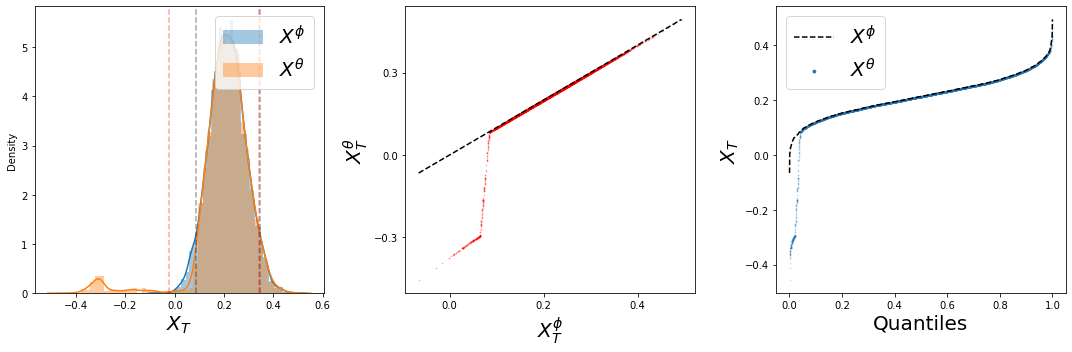

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
inner_net = InnerNet(10).to(device)
outer_net = OuterNet(10).to(device)
inner_name = root_dir + "inner_ab_0.01"
outer_name = root_dir + "outer_ab_0.01"

agent = Robust_Agent(factor_model, sim_params, train_params, device, outer_net, outer_name)
adversary = Robust_Adversary(rm_params, lm_params_1, wass_params_1, train_params, device, inner_net, inner_name)
agent.train(adversary)
np.save(root_dir + "weights_0.01.npy", agent.weights_history)
np.save(root_dir + "X_phi_0.01.npy", agent.X_phi_history)

### Wass 1e-1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Outer Epoch: 0 Outer Iter: 0
### Outer Problem Metrics ###
Weights:  [0.07996421 0.0937818  0.23356554 0.04219628 0.03970255 0.04079868
 0.13603468 0.06073817 0.14471492 0.12850319]
Weights Delta:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
### Inner Problem Metrics ###
Wass Dist History:  [0.10418575257062912, 0.1039537712931633, 0.10205758363008499, 0.10433384031057358, 0.10514422506093979]
Risk Measure X_theta History:  [0.6496134996414185, 0.6466506719589233, 0.6456022262573242, 0.6463537216186523, 0.6442665457725525]
Loss History:  [1.3345279693603516, 1.3313324451446533, 1.2017111778259277, -1.147373080253601, -1.1438871622085571]
Augmented Lagrangian lambda: 7.951062077656387 mu: 151.875


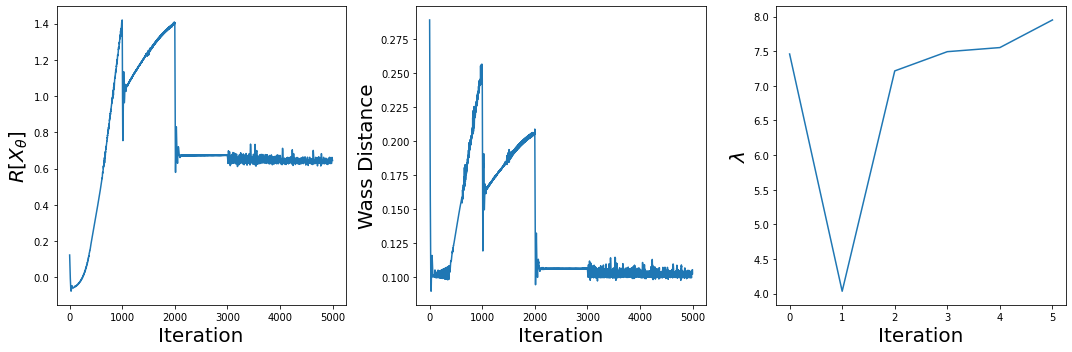

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


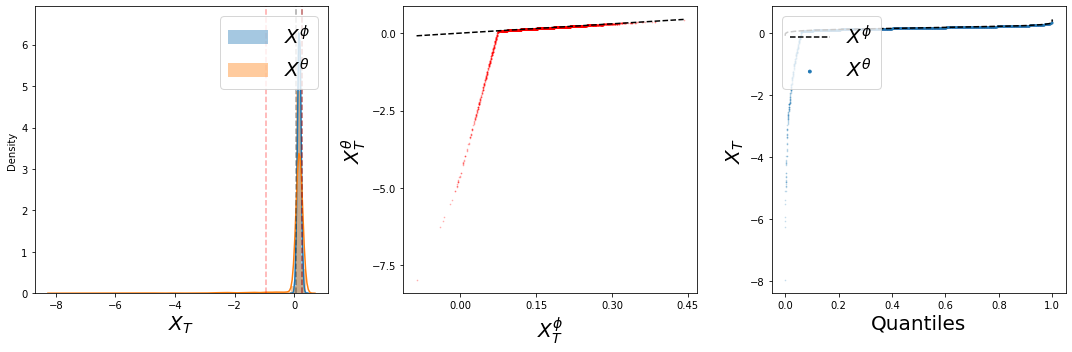

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Outer Epoch: 199 Outer Iter: 0
### Outer Problem Metrics ###
Weights:  [0.02042092 0.02952744 0.11305482 0.14396033 0.14379407 0.12659492
 0.11962628 0.10963267 0.10122567 0.09216291]
Weights Delta:  [-1.09723397e-03 -1.19546056e-03 -6.07438385e-04  6.69926405e-04
  3.40948999e-03  6.65128231e-04  2.04806775e-03 -2.05636024e-06
 -2.31971592e-03 -1.57065690e-03]


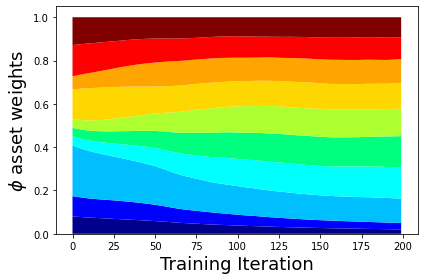

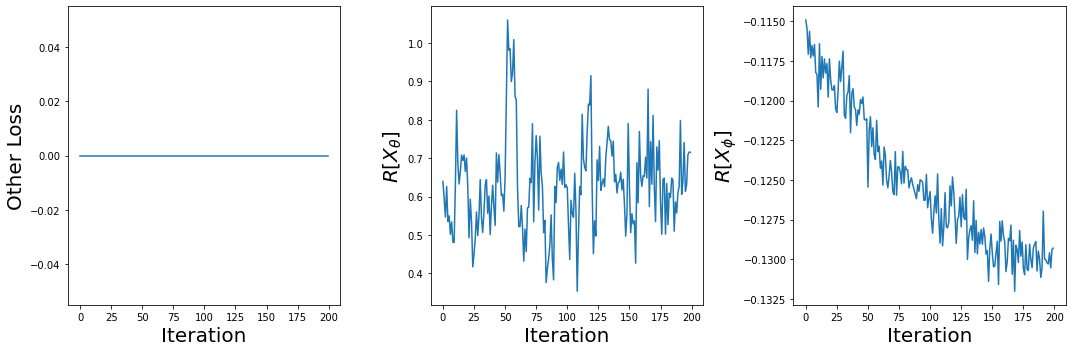

### Inner Problem Metrics ###
Wass Dist History:  [0.10155367106199265, 0.10193094611167908, 0.10174474120140076, 0.1017814353108406, 0.10168807208538055]
Risk Measure X_theta History:  [0.6272399425506592, 0.6289883852005005, 0.6286596059799194, 0.6278613209724426, 0.6280181407928467]
Loss History:  [0.04174886643886566, -0.7869167923927307, 0.09850728511810303, 1.0326265096664429, -0.38975080847740173]
Augmented Lagrangian lambda: 8.116752788424492 mu: 151.875


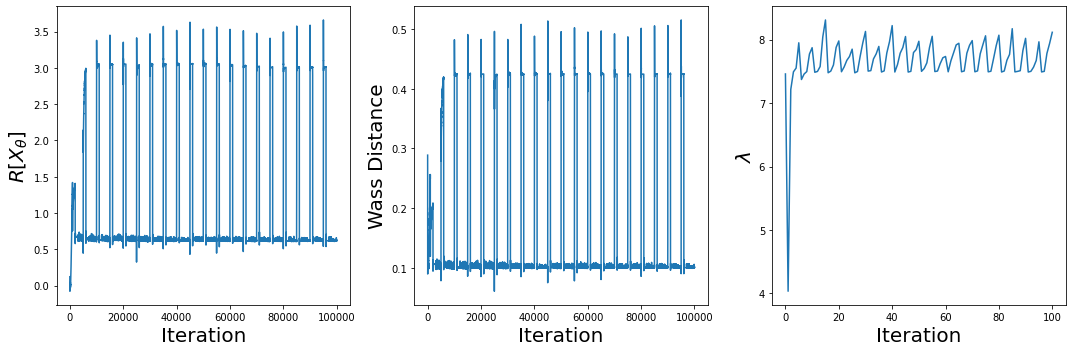

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


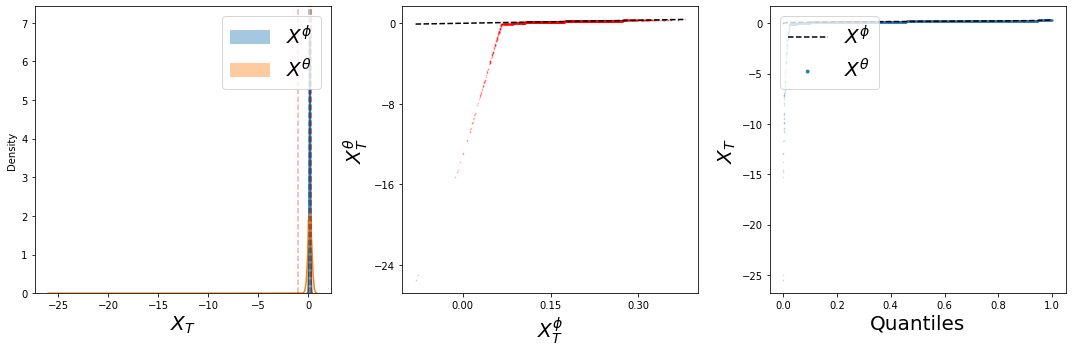

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Outer Epoch: 398 Outer Iter: 0
### Outer Problem Metrics ###
Weights:  [0.0101925  0.02371335 0.13343391 0.14029792 0.14140008 0.12591782
 0.11682001 0.11043186 0.10050754 0.09728499]
Weights Delta:  [-2.91902572e-04 -9.74293798e-05 -2.71086395e-03 -3.36153805e-03
 -8.22424889e-04 -4.02778387e-03 -1.52628124e-03  4.10594046e-03
  2.99912691e-03  5.73317707e-03]


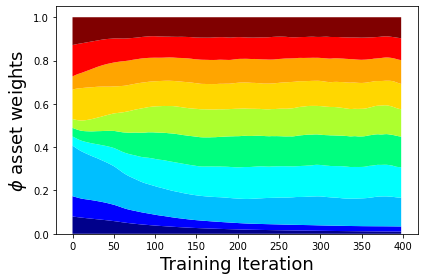

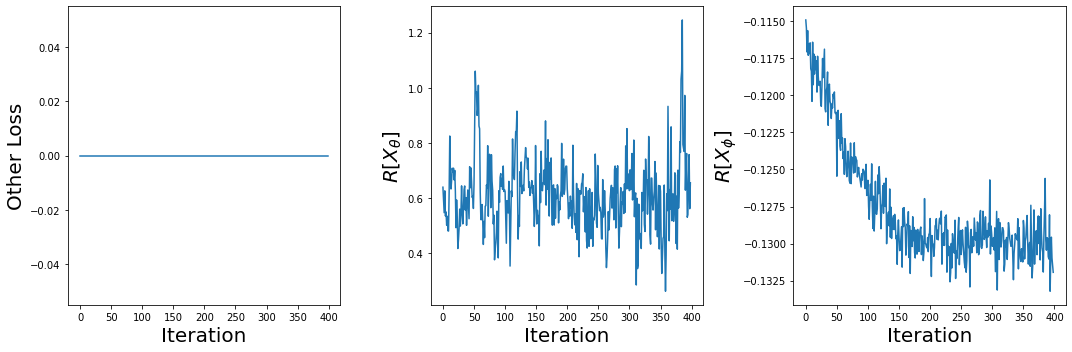

### Inner Problem Metrics ###
Wass Dist History:  [0.1009461060166359, 0.10135633498430252, 0.1015395075082779, 0.10177856683731079, 0.10207848995923996]
Risk Measure X_theta History:  [0.6199443936347961, 0.6228921413421631, 0.6246204972267151, 0.6259993314743042, 0.6280542612075806]
Loss History:  [-0.41749563813209534, -0.422817587852478, 0.18959005177021027, 1.0340074300765991, -0.446376770734787]
Augmented Lagrangian lambda: 7.927788274362682 mu: 151.875


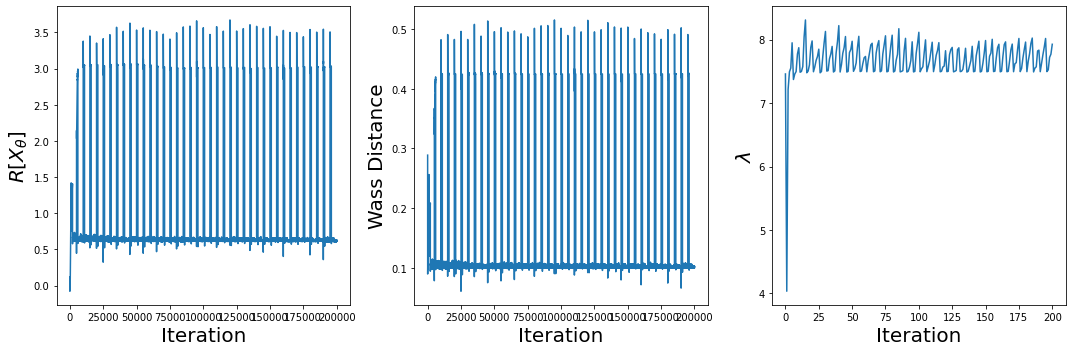

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


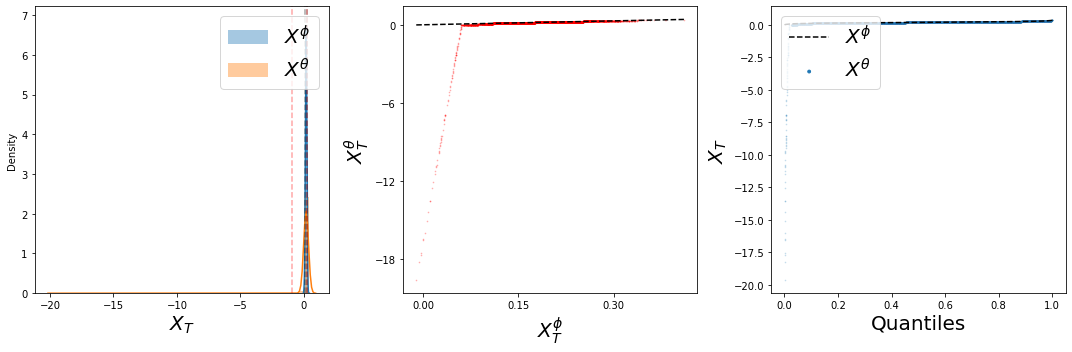

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
inner_net = InnerNet(10).to(device)
outer_net = OuterNet(10).to(device)
inner_name = root_dir + "inner_ab_0.1"
outer_name = root_dir + "outer_ab_0.1"

agent = Robust_Agent(factor_model, sim_params, train_params, device, outer_net, outer_name)
adversary = Robust_Adversary(rm_params, lm_params_2, wass_params_2, train_params, device, inner_net, inner_name)
agent.train(adversary)
np.save(root_dir + "weights_0.1.npy", agent.weights_history)
np.save(root_dir + "X_phi_0.1.npy", agent.X_phi_history)

### Wass 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Outer Epoch: 0 Outer Iter: 0
### Outer Problem Metrics ###
Weights:  [0.05612719 0.08009639 0.20875093 0.03098338 0.03017763 0.15962113
 0.10024925 0.06097822 0.06959219 0.20342365]
Weights Delta:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
### Inner Problem Metrics ###
Wass Dist History:  [1.0347057580947876, 1.0330716371536255, 1.0318777561187744, 1.0307048559188843, 1.0294941663742065]
Risk Measure X_theta History:  [7.556469440460205, 7.544538497924805, 7.534427165985107, 7.5278239250183105, 7.517141819000244]
Loss History:  [0.1707846224308014, 0.5843567252159119, 0.6464568376541138, 0.32289814949035645, 0.10253839939832687]
Augmented Lagrangian lambda: 7.881314831972122 mu: 15.1875


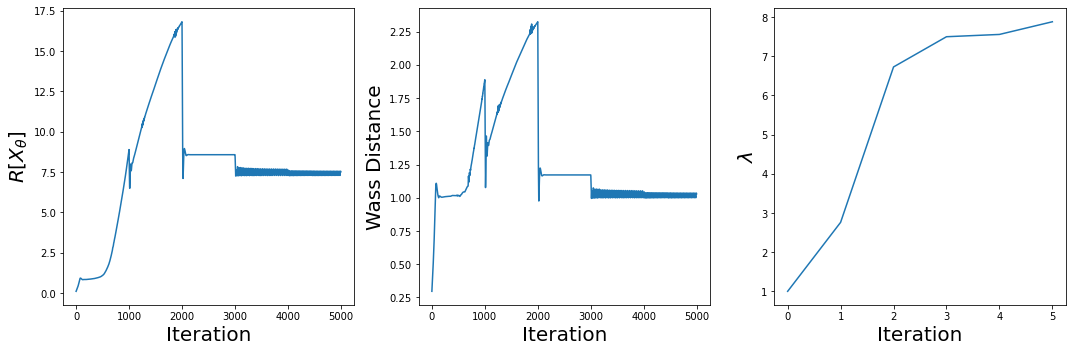

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


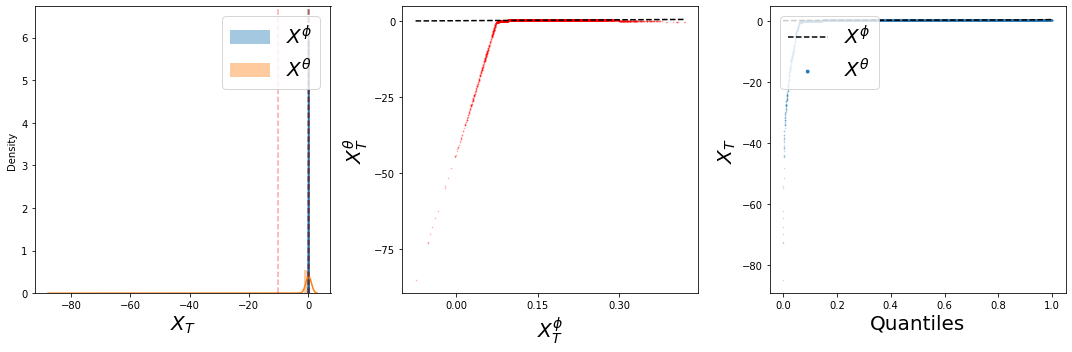

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Outer Epoch: 199 Outer Iter: 0
### Outer Problem Metrics ###
Weights:  [0.01121518 0.02722354 0.12059791 0.14124316 0.14276145 0.1328579
 0.11783582 0.1103425  0.10126253 0.09466002]
Weights Delta:  [-0.00064542 -0.00149348 -0.00116094  0.00156887  0.00194752 -0.00099348
  0.00011905 -0.00012749  0.0011406  -0.00035526]


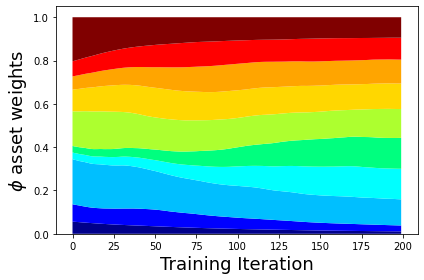

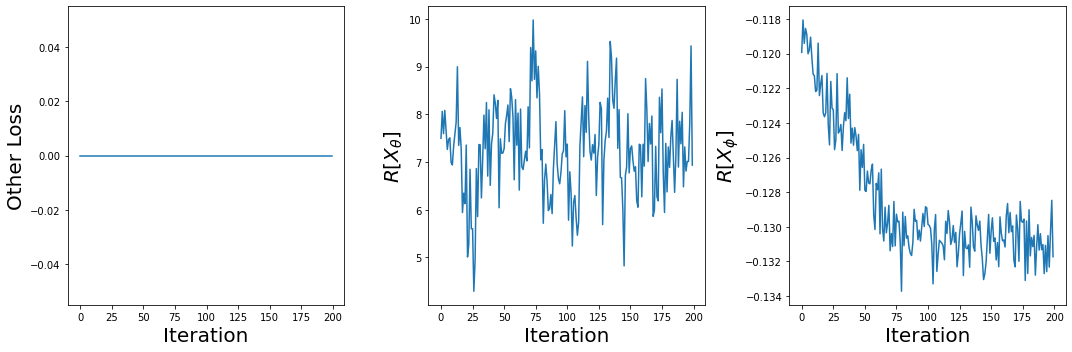

### Inner Problem Metrics ###
Wass Dist History:  [1.0044777393341064, 1.0085349082946777, 1.0111310482025146, 1.0131182670593262, 1.014725923538208]
Risk Measure X_theta History:  [7.29527473449707, 7.325118064880371, 7.345701217651367, 7.360548973083496, 7.372323989868164]
Loss History:  [0.31063005328178406, 0.22765210270881653, 0.3932262361049652, 0.5268706679344177, 0.5667299628257751]
Augmented Lagrangian lambda: 7.927568852901459 mu: 15.1875


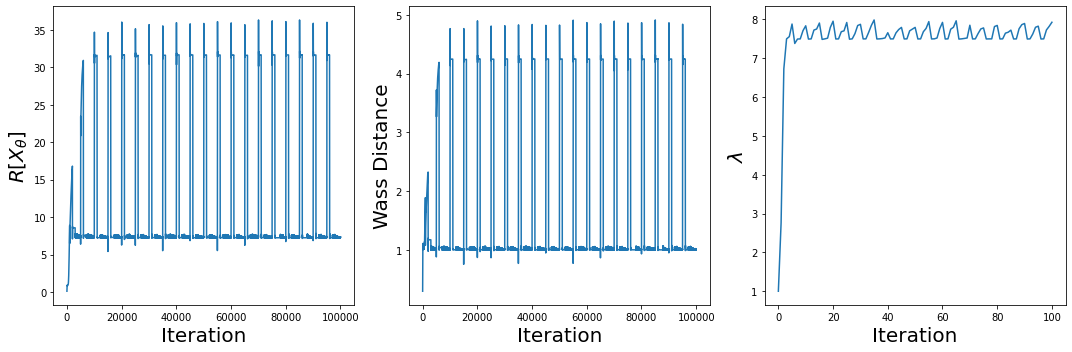

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


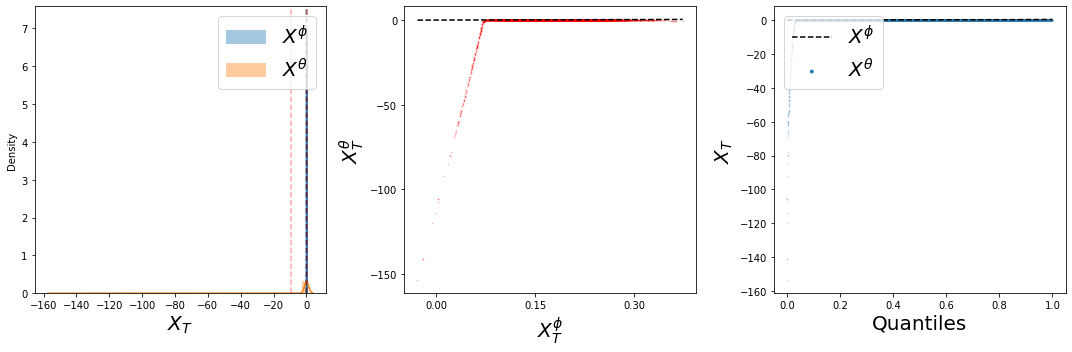

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Outer Epoch: 398 Outer Iter: 0
### Outer Problem Metrics ###
Weights:  [0.0050176  0.01619697 0.12614298 0.14428933 0.14590344 0.1319444
 0.11780256 0.11111537 0.10583996 0.09574738]
Weights Delta:  [-1.20788347e-04 -3.62265855e-05 -9.06318426e-04 -2.21206248e-03
 -1.75899267e-03 -4.99427319e-04 -3.61964107e-04  1.91753358e-03
  1.22427195e-03  2.75392085e-03]


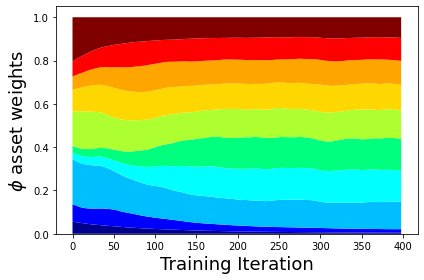

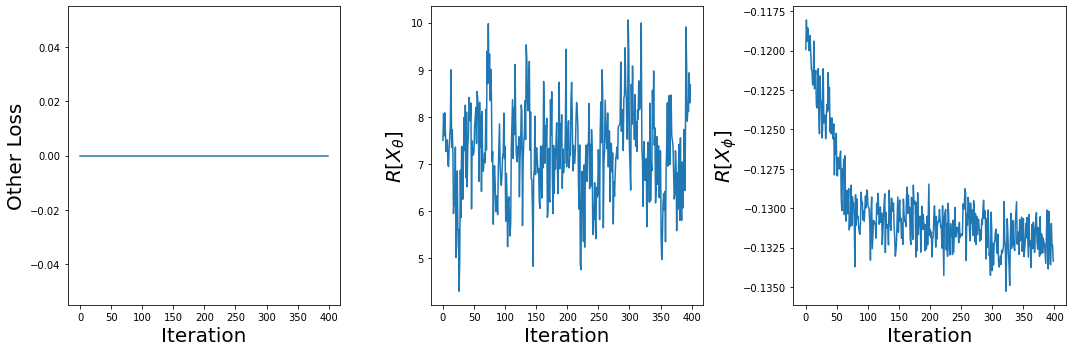

### Inner Problem Metrics ###
Wass Dist History:  [1.0107768774032593, 1.0146762132644653, 1.0176795721054077, 1.0204297304153442, 1.0227727890014648]
Risk Measure X_theta History:  [7.315884113311768, 7.346966743469238, 7.370151996612549, 7.390293121337891, 7.408854961395264]
Loss History:  [0.14356572926044464, 0.24137721955776215, 0.41066181659698486, 0.4842750132083893, 0.44673338532447815]
Augmented Lagrangian lambda: 7.8410139024257655 mu: 15.1875


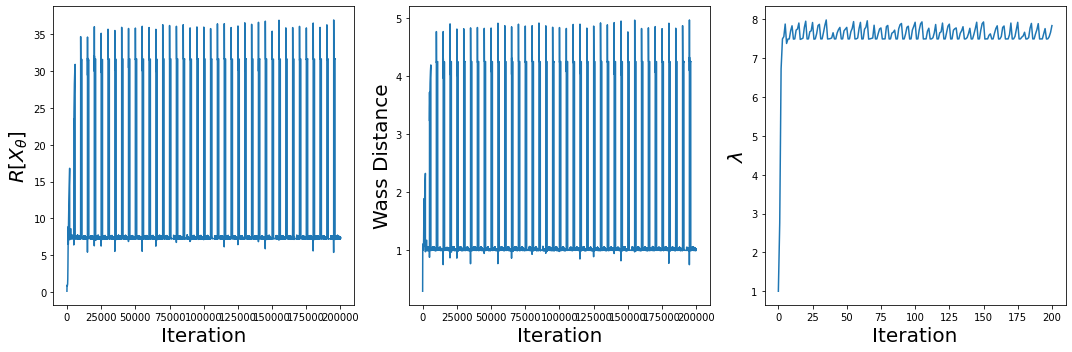

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


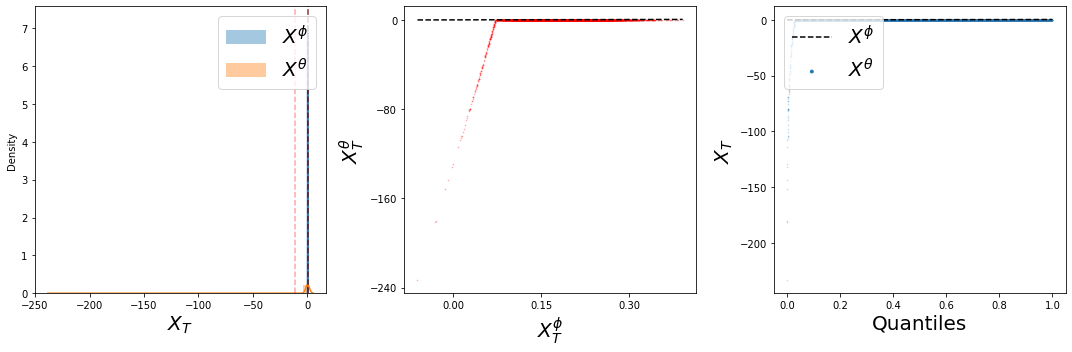

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
inner_net = InnerNet(10).to(device)
outer_net = OuterNet(10).to(device)
inner_name = root_dir + "inner_ab_1"
outer_name = root_dir + "outer_ab_1"

agent = Robust_Agent(factor_model, sim_params, train_params, device, outer_net, outer_name)
adversary = Robust_Adversary(rm_params, lm_params_3, wass_params_3, train_params, device, inner_net, inner_name)
agent.train(adversary)
np.save(root_dir + "weights_1.npy", agent.weights_history)
np.save(root_dir + "X_phi_1.npy", agent.X_phi_history)

# Additional Plots

## Strategy Plots

In [9]:
import matplotlib as mpl
from matplotlib.cm import coolwarm

In [10]:
def PlotStrategy(model_names, wass_iter, outer_net, Nassets):
  num_model = len(model_name_outer)
  weights_history = np.zeros((Nassets, num_model))
  # find strategy weights for each model
  for i in range(num_model):
    zero_tensor = torch.zeros(1).to(device)
    outer_net.load_state_dict(torch.load(root_dir + model_names[i]))
    weights = outer_net(zero_tensor).reshape(-1, 1)
    weights_np = weights.cpu().detach().numpy().squeeze()
    weights_history[:, i] = weights_np

  fig, ax = plt.subplots(figsize = (6,5))
  ax.tick_params(axis='both', labelsize=16)
  colors = ['darkblue', 'blue', 'deepskyblue', 'cyan', 'springgreen', 'greenyellow', 'gold', 'orange', 'red', 'maroon']
  cmap = (mpl.colors.ListedColormap(colors))
  plt.stackplot(wass_iter, weights_history, colors = colors)
  plt.xlabel(r"$\epsilon$", fontsize = 18)
  plt.ylabel(r" $\phi$ portfolio weights", fontsize = 18)
  plt.xscale('log')
  # ensure 10 assets show up in color bar
  bounds = [i for i in range(1, 12)]
  norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
  cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm = norm))
  cbar.set_label('Assets', rotation = 270, labelpad= 18, fontsize = 18)
  # re-centre color bar labels
  labels = np.arange(1,12,1)
  loc    = labels + .5
  cbar.set_ticks(loc)
  cbar.set_ticklabels(labels)
  cbar.ax.tick_params(labelsize=16)
  plt.tight_layout()
  plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


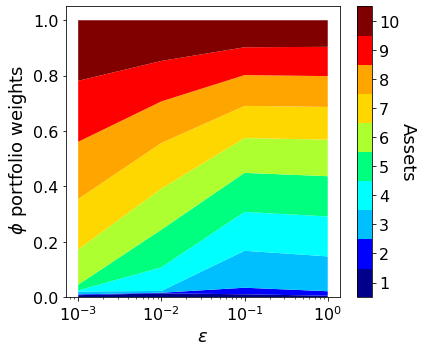

In [11]:
model_names = ["outer_ab_0.001_Epoch_398_Iter_0", "outer_ab_0.01_Epoch_398_Iter_0", "outer_ab_0.1_Epoch_398_Iter_0", "outer_ab_1_Epoch_398_Iter_0"]
wass_iter = [1e-3, 1e-2, 1e-1, 1e-0]
outer_net = OuterNet(10).to(device)
Nassets = 10
PlotStrategy(model_names, wass_iter, outer_net, Nassets)

## Comparison Plots

In [30]:
def PlotComparison(X_phi, X_theta):
  
  plt.figure(figsize = (10 ,5))
  
  plt.subplot(1, 2, 1)
  X, Y, Z = X_phi[:, 0], X_phi[:, 1], X_phi[:, 2]
  sns.distplot(X, hist = True, kde = True, label = r"$\epsilon = 10^{-3}$")
  sns.distplot(Y, hist = True, kde = True, label = r"$\epsilon = 10^{-2}$")
  sns.distplot(Z, hist = True, kde = True, label = r"$\epsilon = 10^{0}$")
  
  plt.axvline(np.mean(X[X<= np.quantile(X,0.1)]),color='b', ls = '--', alpha = 0.35)
  plt.axvline(np.mean(Y[Y<= np.quantile(Y,0.1)]),color='r', ls = '--', alpha = 0.35)
  plt.axvline(np.mean(Z[Z<= np.quantile(Z,0.1)]),color='g', ls = '--', alpha = 0.35)
  plt.axvline(np.mean(X[X>= np.quantile(X,0.9)]),color='b', ls = '--', alpha = 0.35)
  plt.axvline(np.mean(Y[Y>= np.quantile(Y,0.9)]),color='r', ls = '--', alpha = 0.35)
  plt.axvline(np.mean(Z[Z>= np.quantile(Z,0.9)]),color='g', ls = '--', alpha = 0.35)

  plt.xlabel(r'$X^{\phi}$', fontsize = 18)
  plt.ylabel("Density", fontsize = 18)
  plt.legend(loc = "upper right", fontsize = 14)

  plt.subplot(1, 2, 2)
  bins = np.linspace(-20, 5, 125)
  X, Y, Z = X_theta[:, 0], X_theta[:, 1], X_theta[:, 2]
  sns.distplot(X, bins = bins, hist = True, kde = True, kde_kws = {'bw_adjust': 1}, label = r"$\epsilon = 10^{-3}$")
  sns.distplot(Y, bins = bins, hist = True, kde = True, label = r"$\epsilon = 10^{-2}$")
  sns.distplot(Z, bins = bins, hist = True, kde = True, kde_kws = {'bw_adjust': 0.25}, label = r"$\epsilon = 10^{0}$")
  
  plt.axvline(np.mean(X[X<= np.quantile(X,0.1)]),color='b', ls = '--', alpha = 0.35)
  plt.axvline(np.mean(Y[Y<= np.quantile(Y,0.1)]),color='r', ls = '--', alpha = 0.35)
  plt.axvline(np.mean(Z[Z<= np.quantile(Z,0.1)]),color='g', ls = '--', alpha = 0.35)

  plt.xlabel(r'$X^{\theta}$', fontsize = 18)
  plt.ylabel("Density", fontsize = 18)
  plt.yscale('log')
  plt.ylim((1e-3, 10))
  plt.xlim((-6, 1))
  plt.legend(loc = "upper left", fontsize = 16)

  plt.tight_layout()
  plt.show()


In [31]:
sim_param_plts_dict = { "Nassets" : 10,
                   "Nsims" : 7500,
                }

sim_params_plts = Sim_Params(sim_param_plts_dict)

In [ ]:
# re-simulating X_phi and X_theta for plotting purposes with saved outer network models

Nsims = sim_params_plts.params["Nsims"]
model_names = ["outer_ab_0.001_Epoch_398_Iter_0", "outer_ab_0.01_Epoch_398_Iter_0", "outer_ab_1_Epoch_398_Iter_0"]
Nmodels = len(model_names)

outer_net = OuterNet(10).to(device)
inner_net = InnerNet(10).to(device)
# need these to re-train the adversary
lm_params_list = [lm_params_0, lm_params_1, lm_params_3]
wass_params_list = [wass_params_0, wass_params_1, wass_params_3]
# initialize agent but set requires_update flag to False (as we are not training, only producing final)
agent = Robust_Agent(factor_model, sim_params_plts, train_params, device, outer_net, "temp")
agent.requires_update = "False"
agent.InitHistory()
# apply outer strategy models to same set of market scenarios
returns_all = agent.market_model.Sim(sim_params_plts)

for i in range(Nmodels):
  agent.outer_net.load_state_dict(torch.load(root_dir + model_names[i]))
  X_phi_T = agent.sim_phi()
  adversary = Robust_Adversary(rm_params, lm_params_list[i], wass_params_list[i], train_params, device, inner_net, "temp")
  inner_net = adversary.train(X_phi_T.detach(), factor_model)
  X_theta_T = agent.step_theta(X_phi_T, adversary)



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

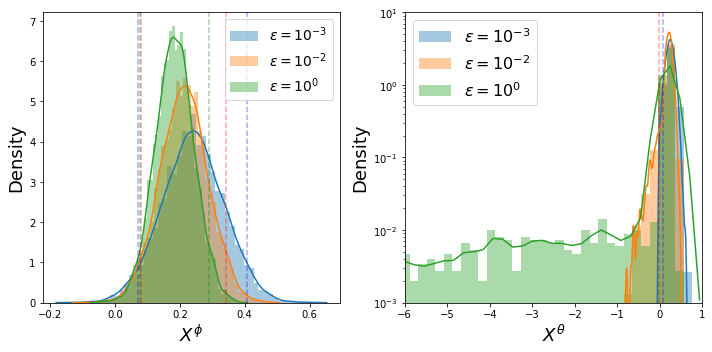

In [32]:
PlotComparison(agent.X_phi_history, agent.X_theta_history)